# MIXED ANALYSIS OF 2022_02_03 and 2022_03_23

In [1]:
import sys

full_path_to_modul_dir = 'D:/mcbj_stmbj'  # here enter the full path to the directory that contains the modul on your computer
sys.path.append(full_path_to_modul_dir)

import re
import os
import warnings
warnings.filterwarnings("error")

In [2]:
from mcbj import *
import filter_traces
import plots
import seaborn as sns
import matplotlib.patches as patches

import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

date_1 = "22_02_03"
date_2 = "22_03_23"
sample_rate = 50_000
home_folder_1 = Path(f"D:/BJ_Data/{date_1}")
home_folder_2 = Path(f"D:/BJ_Data/{date_2}")
# home_folder = Path(f"//DATACENTER/BreakJunction_group/BJ_Data/{date}")

In [3]:
def calc_noise_sim(sim_data_df, dgap=0.0, dphi=0.0, verbose=False):
    """
    Calculates noise from simulation data.
    You can select which parameter you want to be fluctuating and set the other to zero.
    If both values are nonzero, both parameters fluctuate.
    
    Parameters
    ----------
    sim_data_df: `pd.DataFrame` containing data from Laci's simulation software. (best fit parameters)
    dgap: float, gap fluctuation in nm, default: 0.0
    dphi: float, barrier fluctuation in eV, default: 0.0
        
    Returns
    -------
    calculated relative noise (dG/G) with the given fluctuating variables (dgap, dphi).
    """
    
    # 1e-9
    # 1.6e-19
    
    # if dgap is None and dphi is None:
    #     raise ValueError(f'You entered dgap={dgap} and dphi={dphi}. One of them has to be not `None`')
    # elif dgap is None:
    #     print("Calculating relative noise when the barrier fluctuates.")
    #     sim_fluct_relnoise_push = sim_data_df['dR/dPhi'] * dphi * 1.6e-19 / sim_data_df['R [Ohm]']
    # elif dphi is None:
    #     print("Calculating relative noise when the gap fluctuates.")
    #     sim_fluct_relnoise_push = sim_data_df['dR/dz'] * dgap * 1e-9 / sim_data_df['R [Ohm]']
    # else:
    #     print("Calculating relative noise when both the barrier and the gap fluctuates.")
    #     sim_fluct_relnoise_push = np.sqrt((sim_data_df['dR/dz'] * dgap * 1e-9)**2 + (sim_data_df['dR/dPhi'] * dphi * 1.6e-19)**2) / sim_data_df['R [Ohm]']
    #    
    # return sim_fluct_relnoise_push
    if verbose:
        print(f"Calculating relative noise when the barrier fluctuation is dphi={dphi} eV and the gap fluctuation is dgap={dgap} nm.")
    
    # multiply by 1e-9 so the unit is nanometer
    # multiply by 1.6e-19 (unit charge) so the unit is eV
    
    return (np.sqrt((sim_data_df['dR/dz'] * dgap * 1e-9)**2 + (sim_data_df['dR/dPhi'] * dphi * 1.6e-19)**2) / sim_data_df['R [Ohm]']).to_numpy()

In [4]:
def calc_2D_rel_noise_hists(df: pd.DataFrame, x_vars: Tuple[str, ...], y_vars: Tuple[str, ...],                            
                            xrange=(1e-5, 10), yrange=(1e-2, 1), xbins_num=100, ybins_num=100,
                            log_scale=True, bin_mode='total'):
   
    x_bins_all = []
    y_bins_all = []
    x_hist1d_all = []
    y_hist1d_all = []
    x_mesh_all = []
    y_mesh_all = []
    hist2d_all = []
    
    for i in range(len(x_vars)):        
        x_bins, x_hist1d = utils.calc_hist_1d_single(data=df[x_vars[i]], xrange=xrange,
                                                     xbins_num=xbins_num, log_scale=log_scale, bin_mode=bin_mode)
        y_bins, y_hist1d = utils.calc_hist_1d_single(data=df[y_vars[i]], xrange=yrange,
                                                     xbins_num=ybins_num, log_scale=log_scale, bin_mode=bin_mode)

        h, xedges, yedges = np.histogram2d(df[x_vars[i]], df[y_vars[i]],
                                           bins=[x_bins, y_bins])
        x_mesh, y_mesh = np.meshgrid(xedges, yedges)
        
        x_bins_all.append(x_bins)
        y_bins_all.append(y_bins)
        x_hist1d_all.append(x_hist1d)
        y_hist1d_all.append(y_hist1d)
        hist2d_all.append(h.T)
        x_mesh_all.append(x_mesh)
        y_mesh_all.append(y_mesh)
        
    return x_bins_all, x_hist1d_all, y_bins_all, y_hist1d_all, hist2d_all, x_mesh_all, y_mesh_all
    

def plot_2D_rel_noise_hists(df: pd.DataFrame, x_vars: Tuple[str, ...], y_vars: Tuple[str, ...],                            
                            xrange=(1e-5, 10), yrange=(1e-2, 1), xbins_num=100, ybins_num=100,
                            log_scale=True, bin_mode='total', figsize=utils.cm2inch(16, 5), dpi=600,
                            cmap='viridis', **kwargs):
    fig = plt.figure(figsize=figsize, dpi=dpi)
    gs = plt.GridSpec(1, len(x_vars), figure=fig,
                      left=0.08, right=0.92, top=0.9, bottom=0.13,
                      hspace=0.0, wspace=0.0)
    ax = []
    
    xbins_all, x_hist1d_all, ybins_all, y_hist1d_all, hist2d_all, x_mesh_all, y_mesh_all =\
        calc_2D_rel_noise_hists(df=df,
                                x_vars=x_vars, y_vars=y_vars,
                                xrange=xrange, yrange=yrange,
                                xbins_num=xbins_num, ybins_num=ybins_num, log_scale=log_scale, bin_mode=bin_mode)
    
    for i in range(len(x_vars)):
        ax.append(fig.add_subplot(gs[i]))
        im_pull = ax[i].pcolormesh(x_mesh_all[i], y_mesh_all[i], hist2d_all[i], cmap=cmap, **kwargs)
        
        ax[i].tick_params(which='both', left=True, right=True, top=True, bottom=True,
                          labelleft=False, labelright=False, labeltop=False, labelbottom=True)
        ax[i].set_xscale('log')
        ax[i].set_yscale('log')
        ax[i].set_xlabel(x_vars[i])
        ax[i].set_ylabel(y_vars[i])
        
    ax[0].tick_params(which='both',
                      labelleft=True, labelright=False, labeltop=False, labelbottom=True)
    ax[-1].tick_params(which='both',
                      labelleft=False, labelright=True, labeltop=False, labelbottom=True)
    
    return fig, ax
    
def plot_2D_rel_noise_hist_and_scatter(df: pd.DataFrame,
                                       x_2d_vars: Tuple[str, ...], y_2d_vars: Tuple[str, ...],
                                       x_scat_vars: Tuple[str, ...], y_scat_vars: Tuple[str, ...],
                                       xrange=(1e-5, 10), yrange=(1e-2, 1), xbins_num=100, ybins_num=100,
                                       log_scale=True, bin_mode='total', cmap='viridis',
                                       figsize=utils.cm2inch(16, 10), dpi=600, **kwargs):
    
    fig = plt.figure(figsize=figsize, dpi=dpi)
    gs = plt.GridSpec(1, len(x_2d_vars), figure=fig,
                      left=0.08, right=0.92, top=0.9, bottom=0.13,
                      hspace=0.0, wspace=0.0)
    ax = []
    
    xbins_all, x_hist1d_all, ybins_all, y_hist1d_all, hist2d_all, x_mesh_all, y_mesh_all =\
        calc_2D_rel_noise_hists(df=df,
                                x_vars=x_2d_vars, y_vars=y_2d_vars,
                                xrange=xrange, yrange=yrange,
                                xbins_num=xbins_num, ybins_num=ybins_num, log_scale=log_scale, bin_mode=bin_mode)
    
    for i in range(len(x_2d_vars)):
        ax.append(fig.add_subplot(gs[i]))
        im_pull = ax[i].pcolormesh(x_mesh_all[i], y_mesh_all[i], hist2d_all[i], cmap=cmap)
        
        for j in range(len(x_scat_vars)):
            ax[i].scatter(df[x_scat_vars[j]], df[y_scat_vars[j]], **kwargs)
        
        ax[i].tick_params(which='both', left=True, right=True, top=True, bottom=True,
                          labelleft=False, labelright=False, labeltop=False, labelbottom=False)
        ax[i].set_xscale('log')
        ax[i].set_yscale('log')
        ax[i].set_xlabel(x_2d_vars[i])
        ax[i].set_ylabel(x_2d_vars[i])
        
    return fig, ax

In [5]:
sim_data_push_1 = pd.read_excel(io=home_folder_1.joinpath('results/IVs/selected/Tunnel_22_02_03_push_fits_all.xlsx'))
sim_data_push_2 = pd.read_excel(io=home_folder_2.joinpath('results/IVs/Tunnel_22_03_23_push_fits_all.xlsx'))

In [6]:
sim_data_push_2['Part'] = sim_data_push_2['Fit Trace'].map(lambda x: int(re.search(r'(\d)\_IV\w*', x).group(1)))
sim_data_push_2['G [G0]'] = sim_data_push_2['R [Ohm]'].map(utils.convert_ohm_to_g0)

In [7]:
sim_data_push_1['Part'] = sim_data_push_1['Fit Trace'].map(lambda x: int(re.search(r'(\d)\_IV\w*', x).group(1)))
sim_data_push_1['G [G0]'] = sim_data_push_1['R [Ohm]'].map(utils.convert_ohm_to_g0)

In [8]:
noise_push_1 = pd.read_csv(home_folder_1.joinpath('results/IVs/selected/noise_data_push.csv'))

In [9]:
sim_data_push_1 = sim_data_push_1.sort_values(by=['Trace', 'Part'])

In [10]:
sim_data_push_1['G_meas1 [G0]'] = np.vstack((noise_push_1['avg_cond_1'],
                                             noise_push_1['avg_cond_1'], 
                                             noise_push_1['avg_cond_1'], 
                                             noise_push_1['avg_cond_1'])).T.flatten()

sim_data_push_1['G_meas2 [G0]'] = np.vstack((noise_push_1['avg_cond_2'],
                                             noise_push_1['avg_cond_2'], 
                                             noise_push_1['avg_cond_2'], 
                                             noise_push_1['avg_cond_2'])).T.flatten()

sim_data_push_1['dG/G_meas1'] = np.vstack((noise_push_1['conductance_noise_1'],
                                           noise_push_1['conductance_noise_1'], 
                                           noise_push_1['conductance_noise_1'], 
                                           noise_push_1['conductance_noise_1'])).T.flatten()

sim_data_push_1['dG/G_meas2'] = np.vstack((noise_push_1['conductance_noise_2'],
                                           noise_push_1['conductance_noise_2'], 
                                           noise_push_1['conductance_noise_2'], 
                                           noise_push_1['conductance_noise_2'])).T.flatten()

In [11]:
sim_data_push_2 = sim_data_push_2.rename(columns={'G_meas2 [G0]': 'G_meas1 [G0]', 'dG/G_meas2': 'dG/G_meas1', 'G_meas4 [G0]': 'G_meas2 [G0]', 'dG/G_meas4': 'dG/G_meas2'})

In [12]:
sim_data_push_1['date'] = '22_02_03'
sim_data_push_2['date'] = '22_03_23'

In [13]:
sim_data_push_1

,Trace,Fit Trace,R [Ohm],z -Gap [nm],Phi - Barrier [eV],dR/dz,dR/dPhi,G_meas1 [G0],dG/G_meas1,G_meas2 [G0],dG/G_meas2,Part,G [G0],date
0,19515,'1_IV_trace_19515_push_pl',123337740.0,0.43,1.38,1690505688777750016,1.103075e+27,0.000104,0.098067,0.000115,0.046079,1,0.000105,22_02_03
4413,19515,'2_IV_trace_19515_push_pl',115852820.0,0.41,1.54,1670889072724570112,9.379184e+26,0.000104,0.098067,0.000115,0.046079,2,0.000111,22_02_03
8826,19515,'3_IV_trace_19515_push_pl',118121180.0,0.43,1.35,1605310175002129920,1.066052e+27,0.000104,0.098067,0.000115,0.046079,3,0.000109,22_02_03
13239,19515,'4_IV_trace_19515_push_pl',115108080.0,0.48,0.96,1354317457834949888,1.531600e+27,0.000104,0.098067,0.000115,0.046079,4,0.000112,22_02_03
1,19529,'1_IV_trace_19529_push_pl',172076560.0,0.53,0.88,1912228104645339904,2.374670e+27,0.000081,0.070921,0.000086,0.089175,1,0.000075,22_02_03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24874,49083,'4_IV_trace_49083_push_pl',93806128.0,0.35,2.20,1595239425253939968,5.499750e+26,0.000113,0.088571,0.000294,0.168821,4,0.000138,22_02_03
19457,49088,'1_IV_trace_49088_push_pl',195853160.0,0.47,1.33,2604451377963440128,1.969822e+27,0.000067,0.066466,0.000087,0.032976,1,0.000066,22_02_03
21263,49088,'2_IV_trace_49088_push_pl',201705620.0,0.50,1.13,2508884239892480000,2.352905e+27,0.000067,0.066466,0.000087,0.032976,2,0.000064,22_02_03
23069,49088,'3_IV_trace_49088_push_pl',224151430.0,0.52,1.06,2703746584815159808,2.815920e+27,0.000067,0.066466,0.000087,0.032976,3,0.000058,22_02_03


In [14]:
sim_data_push_2

,Trace,Fit Trace,R [Ohm],z -Gap [nm],Phi - Barrier [eV],dR/dz,dR/dPhi,G_meas1 [G0],dG/G_meas1,G_meas2 [G0],dG/G_meas2,Part,G [G0],date
0,25239,'1_IV_trace_25239_push_pl',3.263771e+06,0.19,1.14,4.848058e+16,1.225654e+25,0.003038,0.032679,0.003845,0.045625,1,0.003952,22_03_23
1,25343,'1_IV_trace_25343_push_pl',4.393932e+06,0.22,0.95,6.048570e+16,2.073527e+25,0.008576,0.206788,0.004134,0.084215,1,0.002936,22_03_23
2,25359,'1_IV_trace_25359_push_pl',2.913397e+06,0.19,0.96,4.128007e+16,1.397828e+25,0.006109,0.032226,0.004866,0.019054,1,0.004428,22_03_23
3,25410,'1_IV_trace_25410_push_pl',4.990767e+06,0.21,1.34,7.656266e+16,1.987623e+25,0.002352,0.019966,0.002520,0.027508,1,0.002585,22_03_23
4,25438,'1_IV_trace_25438_push_pl',1.201346e+06,0.11,1.88,2.170211e+16,2.110191e+24,0.010455,0.044790,0.011408,0.022727,1,0.010738,22_03_23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4491,34168,'4_IV_trace_34168_push_pl',1.969823e+06,0.16,1.03,2.919545e+16,6.096039e+24,0.009005,0.051511,0.004081,0.036337,4,0.006549,22_03_23
4492,34173,'4_IV_trace_34173_push_pl',6.294077e+06,0.23,1.24,9.299089e+16,2.855777e+25,0.001617,0.081721,0.001663,0.054082,4,0.002050,22_03_23
4493,34175,'4_IV_trace_34175_push_pl',2.633340e+06,0.19,0.81,3.569414e+16,1.069254e+25,0.006712,0.098494,0.004635,0.025815,4,0.004899,22_03_23
4494,34185,'4_IV_trace_34185_push_pl',1.912974e+06,0.15,1.29,3.031204e+16,5.297626e+24,0.006658,0.091355,0.007541,0.065379,4,0.006743,22_03_23


In [15]:
sim_data_mix = pd.concat([sim_data_push_1, sim_data_push_2])

In [16]:
sim_data_mix

,Trace,Fit Trace,R [Ohm],z -Gap [nm],Phi - Barrier [eV],dR/dz,dR/dPhi,G_meas1 [G0],dG/G_meas1,G_meas2 [G0],dG/G_meas2,Part,G [G0],date
0,19515,'1_IV_trace_19515_push_pl',1.233377e+08,0.43,1.38,1.690506e+18,1.103075e+27,0.000104,0.098067,0.000115,0.046079,1,0.000105,22_02_03
4413,19515,'2_IV_trace_19515_push_pl',1.158528e+08,0.41,1.54,1.670889e+18,9.379184e+26,0.000104,0.098067,0.000115,0.046079,2,0.000111,22_02_03
8826,19515,'3_IV_trace_19515_push_pl',1.181212e+08,0.43,1.35,1.605310e+18,1.066052e+27,0.000104,0.098067,0.000115,0.046079,3,0.000109,22_02_03
13239,19515,'4_IV_trace_19515_push_pl',1.151081e+08,0.48,0.96,1.354317e+18,1.531600e+27,0.000104,0.098067,0.000115,0.046079,4,0.000112,22_02_03
1,19529,'1_IV_trace_19529_push_pl',1.720766e+08,0.53,0.88,1.912228e+18,2.374670e+27,0.000081,0.070921,0.000086,0.089175,1,0.000075,22_02_03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4491,34168,'4_IV_trace_34168_push_pl',1.969823e+06,0.16,1.03,2.919545e+16,6.096039e+24,0.009005,0.051511,0.004081,0.036337,4,0.006549,22_03_23
4492,34173,'4_IV_trace_34173_push_pl',6.294077e+06,0.23,1.24,9.299089e+16,2.855777e+25,0.001617,0.081721,0.001663,0.054082,4,0.002050,22_03_23
4493,34175,'4_IV_trace_34175_push_pl',2.633340e+06,0.19,0.81,3.569414e+16,1.069254e+25,0.006712,0.098494,0.004635,0.025815,4,0.004899,22_03_23
4494,34185,'4_IV_trace_34185_push_pl',1.912974e+06,0.15,1.29,3.031204e+16,5.297626e+24,0.006658,0.091355,0.007541,0.065379,4,0.006743,22_03_23


In [17]:
sim_data_mix['dG/G_sim_gap'] = calc_noise_sim(sim_data_mix, dgap=3e-3, dphi=0)
sim_data_mix['dG/G_sim_phi'] = calc_noise_sim(sim_data_mix, dgap=0, dphi=33e-3)
sim_data_mix['dG/G_sim_gap_phi'] = calc_noise_sim(sim_data_mix, dgap=1.5e-3, dphi=33e-3)

In [18]:
my_cmap = ListedColormap(np.vstack((np.array([1., 1., 1., 0.]).reshape(1, -1), colormaps['viridis'](np.linspace(0.0, 1.0, 31)))))


my_cmap_blues = ListedColormap(np.vstack((np.array([1., 1., 1., 0.]).reshape(1, -1),
                                          colormaps['viridis'](np.linspace(0.0, 1.0, 31)))))
my_cmap_reds = ListedColormap(np.vstack((np.array([1., 1., 1., 0.]).reshape(1, -1),
                                         colormaps['plasma'](np.linspace(0.0, 1.0, 31)))))

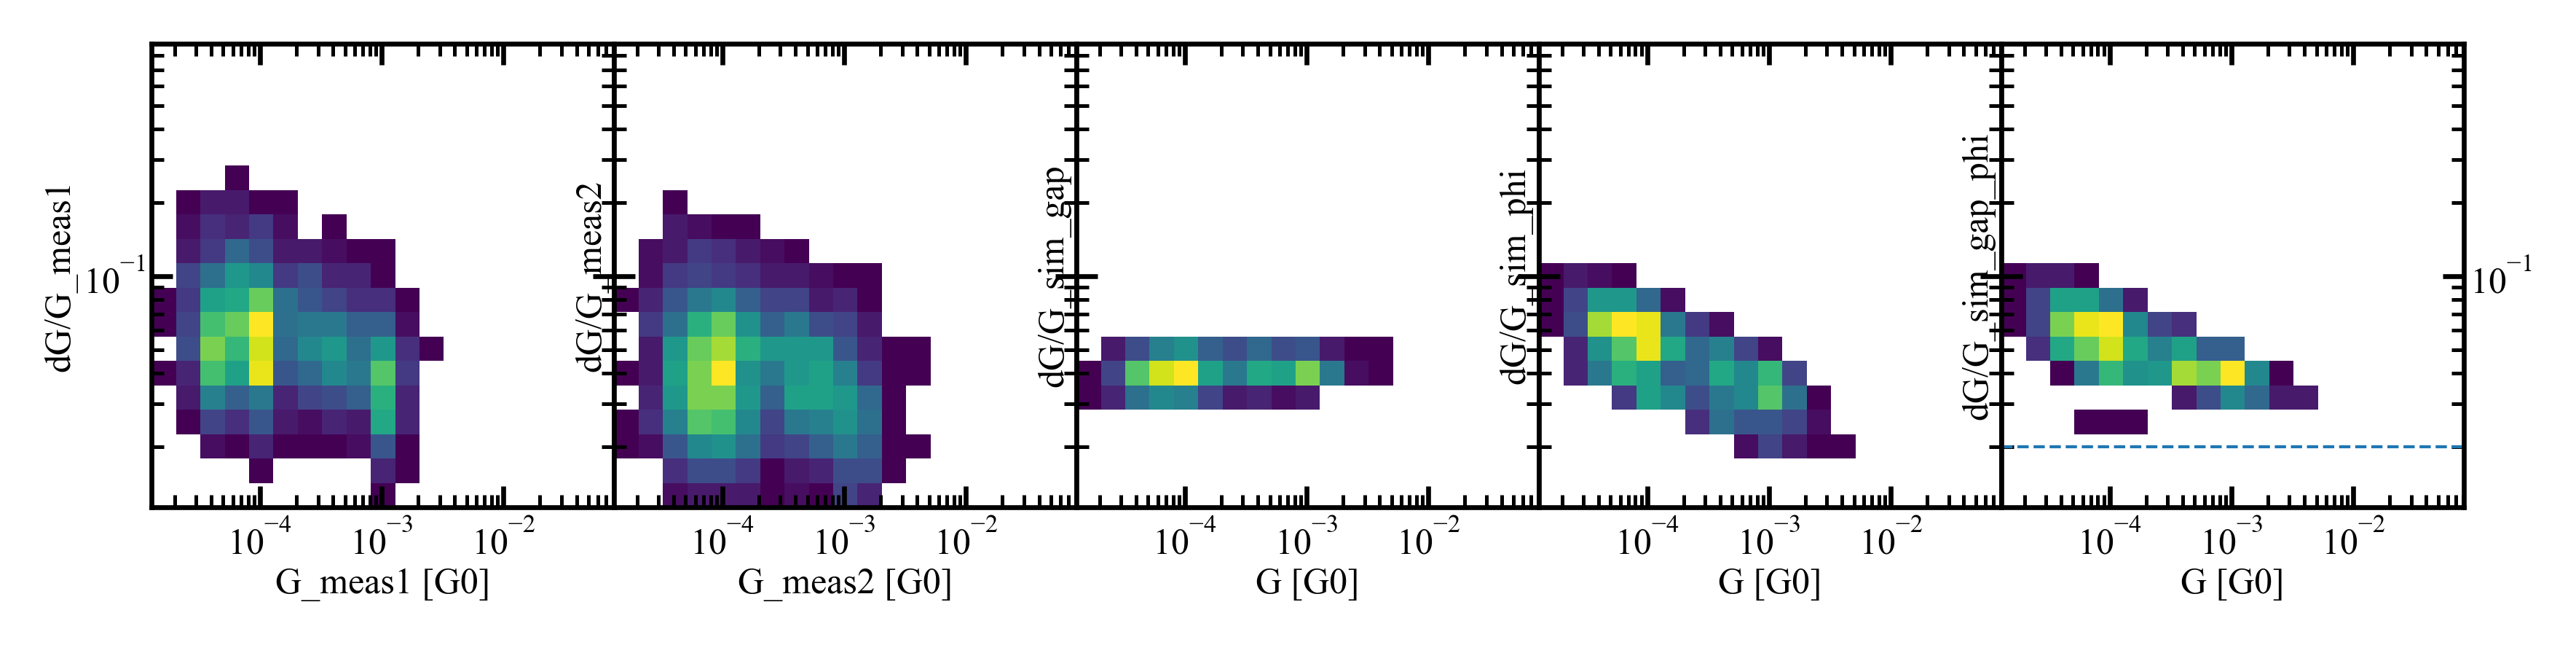

In [19]:
fig, ax = plot_2D_rel_noise_hists(sim_data_mix,
                                  x_vars=('G_meas1 [G0]', 'G_meas2 [G0]', 'G [G0]', 'G [G0]', 'G [G0]'),
                                  y_vars=('dG/G_meas1', 'dG/G_meas2', 'dG/G_sim_gap', 'dG/G_sim_phi', 'dG/G_sim_gap_phi'),
                                  xrange=(1e-5, 1e-1), yrange=(1e-2, 1), xbins_num=20, ybins_num=20, cmap=my_cmap_blues, figsize=utils.cm2inch(16, 3.5))

ax[-1].axhline(2e-2, ls='--', lw=0.5)

In [20]:
x_bins_all, x_hist1d_all, y_bins_all, y_hist1d_all, hist2d_all, x_mesh_all, y_mesh_all =\
    calc_2D_rel_noise_hists(df=sim_data_mix,
                            x_vars=('G_meas1 [G0]', 'G_meas2 [G0]', 'G [G0]', 'G [G0]', 'G [G0]'),
                            y_vars=('dG/G_meas1', 'dG/G_meas2', 'dG/G_sim_gap', 'dG/G_sim_phi', 'dG/G_sim_gap_phi'),                            
                            xrange=(1e-5, 10), yrange=(1e-2, 1), xbins_num=10, ybins_num=10,
                            log_scale=True, bin_mode='decade')

In [21]:
hist2d_all[0]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 4., 4., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [22]:
from numpy.polynomial import Polynomial

In [23]:
dFluct = np.arange(start=0, stop=0.0151, step=0.0001) ## stop/3
PhiFluct = np.arange(start=0.001, stop=0.151, step=0.001) ## stop/3

In [24]:
sim_data_mix

,Trace,Fit Trace,R [Ohm],z -Gap [nm],Phi - Barrier [eV],dR/dz,dR/dPhi,G_meas1 [G0],dG/G_meas1,G_meas2 [G0],dG/G_meas2,Part,G [G0],date,dG/G_sim_gap,dG/G_sim_phi,dG/G_sim_gap_phi
0,19515,'1_IV_trace_19515_push_pl',1.233377e+08,0.43,1.38,1.690506e+18,1.103075e+27,0.000104,0.098067,0.000115,0.046079,1,0.000105,22_02_03,0.041119,0.047222,0.051503
4413,19515,'2_IV_trace_19515_push_pl',1.158528e+08,0.41,1.54,1.670889e+18,9.379184e+26,0.000104,0.098067,0.000115,0.046079,2,0.000111,22_02_03,0.043268,0.042746,0.047908
8826,19515,'3_IV_trace_19515_push_pl',1.181212e+08,0.43,1.35,1.605310e+18,1.066052e+27,0.000104,0.098067,0.000115,0.046079,3,0.000109,22_02_03,0.040771,0.047652,0.051830
13239,19515,'4_IV_trace_19515_push_pl',1.151081e+08,0.48,0.96,1.354317e+18,1.531600e+27,0.000104,0.098067,0.000115,0.046079,4,0.000112,22_02_03,0.035297,0.070254,0.072437
1,19529,'1_IV_trace_19529_push_pl',1.720766e+08,0.53,0.88,1.912228e+18,2.374670e+27,0.000081,0.070921,0.000086,0.089175,1,0.000075,22_02_03,0.033338,0.072864,0.074747
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4491,34168,'4_IV_trace_34168_push_pl',1.969823e+06,0.16,1.03,2.919545e+16,6.096039e+24,0.009005,0.051511,0.004081,0.036337,4,0.006549,22_03_23,0.044464,0.016340,0.027591
4492,34173,'4_IV_trace_34173_push_pl',6.294077e+06,0.23,1.24,9.299089e+16,2.855777e+25,0.001617,0.081721,0.001663,0.054082,4,0.002050,22_03_23,0.044323,0.023957,0.032635
4493,34175,'4_IV_trace_34175_push_pl',2.633340e+06,0.19,0.81,3.569414e+16,1.069254e+25,0.006712,0.098494,0.004635,0.025815,4,0.004899,22_03_23,0.040664,0.021439,0.029547
4494,34185,'4_IV_trace_34185_push_pl',1.912974e+06,0.15,1.29,3.031204e+16,5.297626e+24,0.006658,0.091355,0.007541,0.065379,4,0.006743,22_03_23,0.047537,0.014622,0.027906


In [114]:
# dRpR = np.empty((dFluct.shape[0], PhiFluct.shape[0], sim_data_mix.shape[0]))
dRpR = {}

for i, dz in enumerate(dFluct):
    for j, dP in enumerate(PhiFluct):
        # dRpR[i, j] = calc_noise_sim(sim_data_df=sim_data_mix, dgap=dz, dphi=dP)
        relative_noise = calc_noise_sim(sim_data_df=sim_data_mix, dgap=dz, dphi=dP)
        dGpG[(dz, dP)] = relative_noise
        
        x = np.log10(sim_data_mix['G [G0]'].to_numpy())
        y = np.log10(relative_noise)
        
        sorter_arr = np.argsort(x)
        
        p_fit = Polynomial.fit(x=x[sorter_arr], y=y[sorter_arr], deg=5)  # fit a degree 5 polynomial to the simulated data

In [117]:
# dRpR

In [128]:
dz = dFluct[2]
dP = PhiFluct[1]

relative_noise = calc_noise_sim(sim_data_df=sim_data_mix, dgap=dz, dphi=dP)

x = np.log10(sim_data_mix['G [G0]'].to_numpy())
y = np.log10(relative_noise)

sorter_arr = np.argsort(x)

p_fit = Polynomial.fit(x=x[sorter_arr], y=y[sorter_arr], deg=5)

In [129]:
10**p_fit(np.log10(sim_data_mix['G [G0]'].to_numpy()))

array([0.02695947, 0.02701993, 0.02700128, ..., 0.02965458, 0.03124449,
       0.02819912])

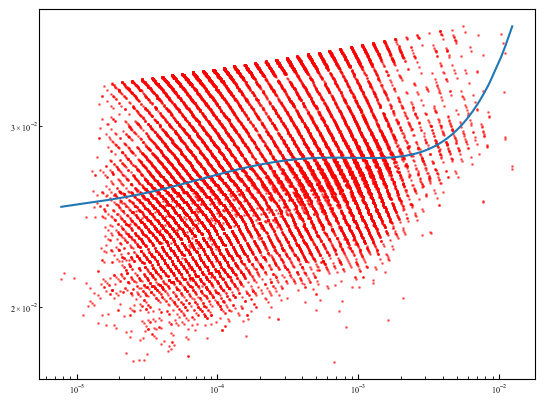

In [132]:
x = sim_data_mix['G [G0]'].to_numpy()
y = 10**p_fit(np.log10(x))

fig, ax = plt.subplots(1)

ax.scatter(sim_data_mix['G [G0]'].to_numpy(), relative_noise, c='r', alpha=0.5, s=1)
ax.plot(x[sorter_arr], y[sorter_arr])
ax.set_xscale('log')
ax.set_yscale('log')

  0%|          | 0/5 [00:00<?, ?it/s]

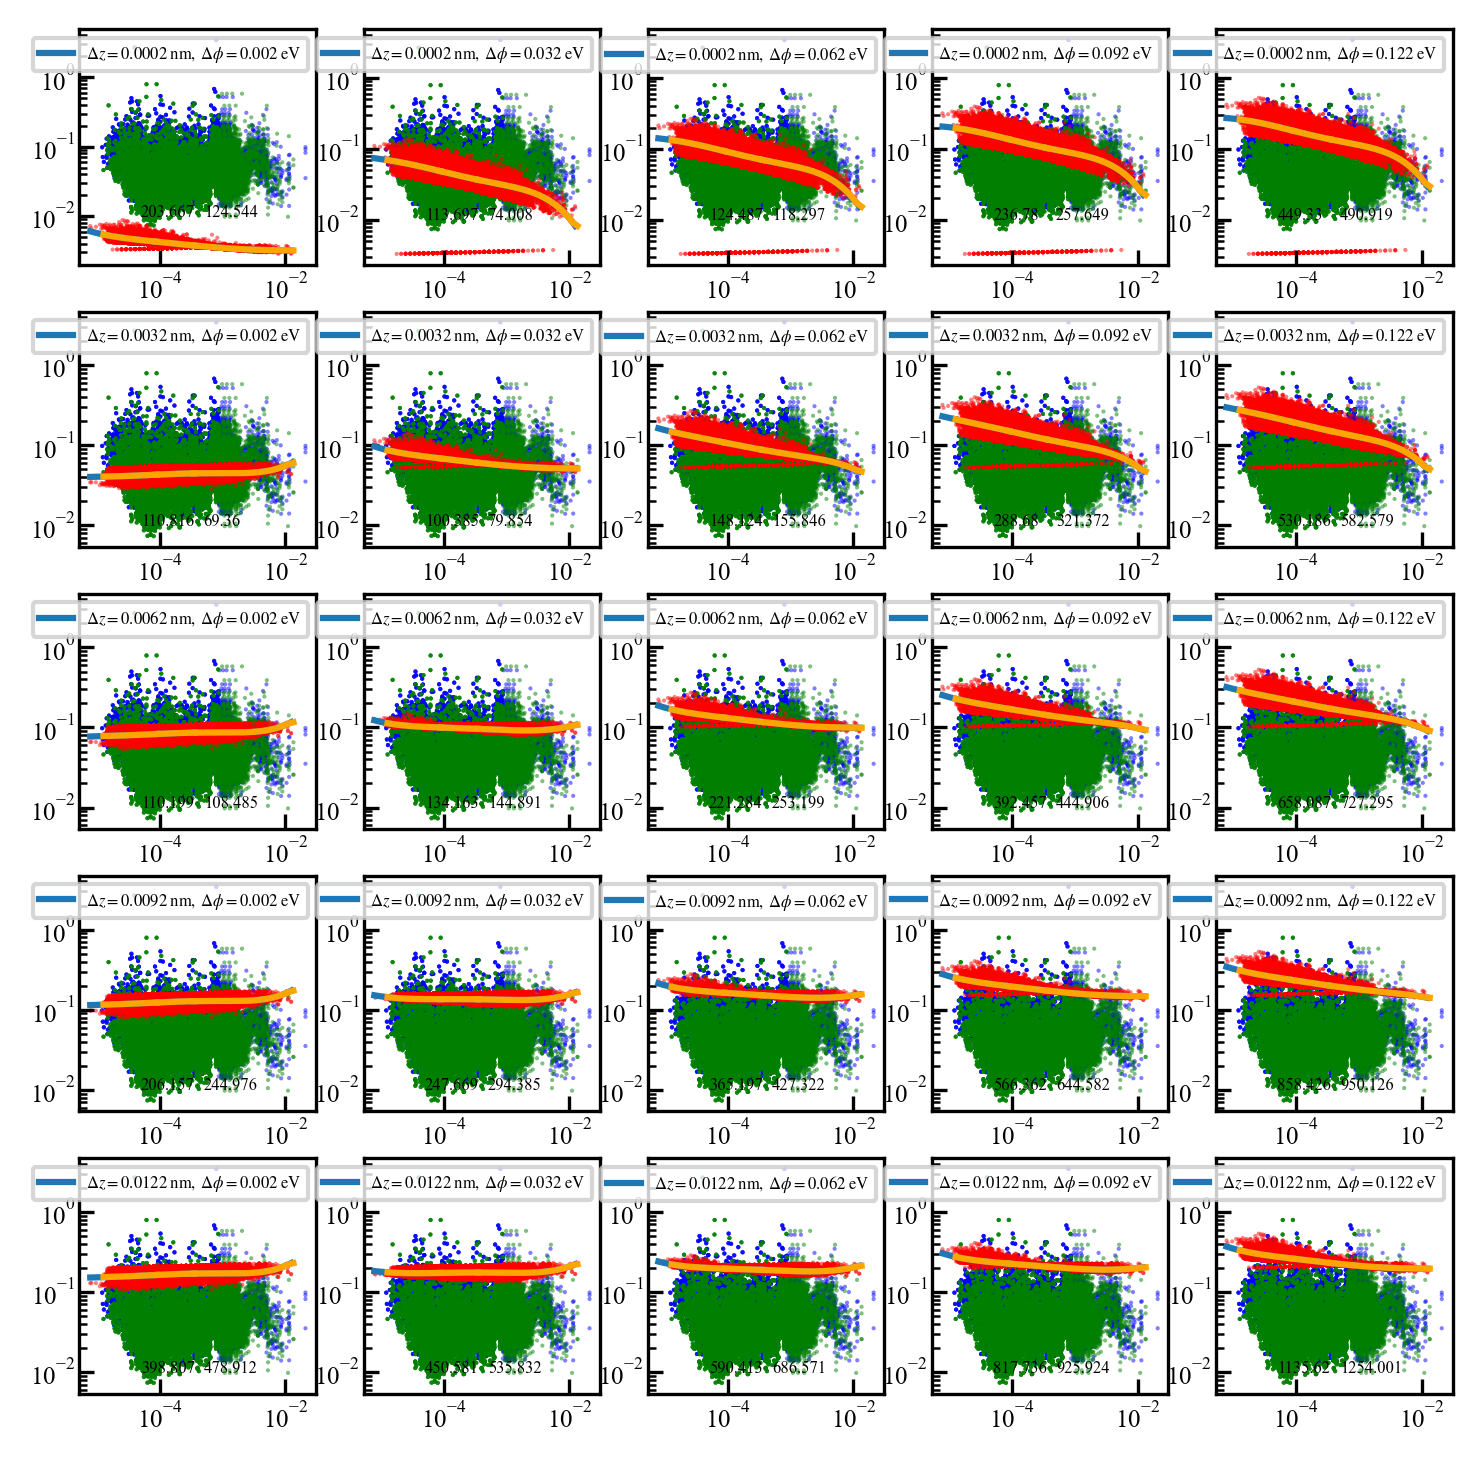

In [275]:
fig, ax = plt.subplots(5, 5, figsize=utils.cm2inch(15, 15), dpi=300)

asd = []

sqr_diff_all_1 = np.zeros((dFluct.shape[0], PhiFluct.shape[0]))
sqr_diff_all_2 = np.zeros((dFluct.shape[0], PhiFluct.shape[0]))
for i, dz in enumerate(tqdm(dFluct[1::30])):
    for j, dP in enumerate(PhiFluct[1::30]):
        
        # calculate the simulated relative noise
        relative_noise = calc_noise_sim(sim_data_df=sim_data_mix, dgap=dz, dphi=dP)
        
        # calculate the log of the simulation conductance and relative noise as x and y respectively
        x = np.log10(sim_data_mix['G [G0]'].to_numpy())
        y = np.log10(relative_noise)
        
        # sort by conductance
        sorter_arr = np.argsort(x)
        x = x[sorter_arr]
        y = y[sorter_arr]
        # fit degree 5 polynomial to simulated data
        p_fit = Polynomial.fit(x=x, y=y, deg=5)
        
        # evaluate fitted polynomial at simulation conductance points
        x_fit = sim_data_mix['G [G0]'].to_numpy()[sorter_arr]
        y_fit = 10**p_fit(np.log10(x_fit))
        
        # interpolate for the measurement data
        x_int_1 = sim_data_mix['G_meas1 [G0]'].to_numpy()
        sorter_1 = np.argsort(x_int_1)
        x_int_1 = x_int_1[sorter_1]
        
        y_int_1 = np.interp(x_int_1, x_fit, y_fit)
        y_meas_1 = sim_data_mix['dG/G_meas1'].to_numpy()
        
        x_int_2 = sim_data_mix['G_meas2 [G0]'].to_numpy()
        sorter_2 = np.argsort(x_int_2)
        x_int_2 = x_int_2[sorter_2]
        
        y_int_2 = np.interp(x_int_2, x_fit, y_fit)
        y_meas_2 = sim_data_mix['dG/G_meas2'].to_numpy()
        
        sq_diff_1 = np.sum((y_int_1 - y_meas_1)**2)
        sq_diff_2 = np.sum((y_int_2 - y_meas_2)**2)
        
        sqr_diff_all_1[i, j] = sq_diff_1
        sqr_diff_all_2[i, j] = sq_diff_2
        
        ax[i, j].scatter(x_int_1, y_meas_1, c='blue', alpha=0.5, s=1, edgecolor='None')
        ax[i, j].scatter(x_int_2, y_meas_2, c='green', alpha=0.5, s=1, edgecolor='None')
        ax[i, j].scatter(sim_data_mix['G [G0]'].to_numpy(), relative_noise, c='r', alpha=0.5, s=1, edgecolor='None')
        ax[i, j].plot(x_fit, y_fit, label=r'$\Delta z = ' + str(np.round(dz, 4)) + r'\;\mathrm{nm},\;' + r'\Delta \phi = ' + str(np.round(dP, 3)) + r'\;\mathrm{eV}$')
        # ax[i, j].plot(x_int_1, y_int_1, c='orange')
        ax[i, j].plot(x_int_2, y_int_2, c='orange')
        ax[i, j].set_xscale('log')
        ax[i, j].set_yscale('log')
        ax[i, j].legend(fontsize=4)
        
        ax[i, j].text(x=5e-5, y=1e-2, s=str(np.round(sq_diff_1, 3)), fontsize=4)
        ax[i, j].text(x=5e-4, y=1e-2, s=str(np.round(sq_diff_2, 3)), fontsize=4)
        
        
        # print(r'$\Delta z = ' + str(np.round(dz, 3)) + r'\;\mathrm{nm},\;' + r'\Delta \Phi = ' + str(np.round(dP, 3)) + r'\;\mathrm{eV}$')

In [325]:
sim_data_mix[sim_data_mix['Phi - Barrier [eV]'] < 2.25]

,Trace,Fit Trace,R [Ohm],z -Gap [nm],Phi - Barrier [eV],dR/dz,dR/dPhi,G_meas1 [G0],dG/G_meas1,G_meas2 [G0],...,date,dG/G_sim_gap,dG/G_sim_phi,dG/G_sim_gap_phi,dG/G_sim_1,dG/G_sim_2,dG/G_sim_3,dG/G_sim_4,dG/G_sim_5,dG/G_sim_6
0,19515,'1_IV_trace_19515_push_pl',1.233377e+08,0.43,1.38,1.690506e+18,1.103075e+27,0.000104,0.098067,0.000115,...,22_02_03,0.041119,0.047222,0.051503,0.067176,0.046657,0.053474,0.052104,0.064351,0.047993
4413,19515,'2_IV_trace_19515_push_pl',1.158528e+08,0.41,1.54,1.670889e+18,9.379184e+26,0.000104,0.098067,0.000115,...,22_02_03,0.043268,0.042746,0.047908,0.070682,0.048709,0.056263,0.054821,0.067360,0.050495
8826,19515,'3_IV_trace_19515_push_pl',1.181212e+08,0.43,1.35,1.605310e+18,1.066052e+27,0.000104,0.098067,0.000115,...,22_02_03,0.040771,0.047652,0.051830,0.066608,0.046312,0.053022,0.051664,0.063852,0.047588
13239,19515,'4_IV_trace_19515_push_pl',1.151081e+08,0.48,0.96,1.354317e+18,1.531600e+27,0.000104,0.098067,0.000115,...,22_02_03,0.035297,0.070254,0.072437,0.057691,0.042398,0.045935,0.044760,0.057413,0.041235
1,19529,'1_IV_trace_19529_push_pl',1.720766e+08,0.53,0.88,1.912228e+18,2.374670e+27,0.000081,0.070921,0.000086,...,22_02_03,0.033338,0.072864,0.074747,0.054497,0.040704,0.043396,0.042286,0.054845,0.038957
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4491,34168,'4_IV_trace_34168_push_pl',1.969823e+06,0.16,1.03,2.919545e+16,6.096039e+24,0.009005,0.051511,0.004081,...,22_03_23,0.044464,0.016340,0.027591,0.072626,0.049071,0.057805,0.056323,0.068324,0.051877
4492,34173,'4_IV_trace_34173_push_pl',6.294077e+06,0.23,1.24,9.299089e+16,2.855777e+25,0.001617,0.081721,0.001663,...,22_03_23,0.044323,0.023957,0.032635,0.072398,0.049100,0.057625,0.056147,0.068275,0.051715
4493,34175,'4_IV_trace_34175_push_pl',2.633340e+06,0.19,0.81,3.569414e+16,1.069254e+25,0.006712,0.098494,0.004635,...,22_03_23,0.040664,0.021439,0.029547,0.066421,0.045031,0.052867,0.051512,0.062625,0.047446
4494,34185,'4_IV_trace_34185_push_pl',1.912974e+06,0.15,1.29,3.031204e+16,5.297626e+24,0.006658,0.091355,0.007541,...,22_03_23,0.047537,0.014622,0.027906,0.077644,0.052410,0.061799,0.060215,0.072998,0.055461


In [210]:
28985/4

7246.25

In [25]:
def fit_poly_to_sim(x, y, log_scale=True, poly_deg=5):
    x_fit = np.copy(x)
    if log_scale:
        x = np.log10(x)
        y = np.log10(y)
        
    # sort by x
    sorter_arr = np.argsort(x)
    x = x[sorter_arr]
    y = y[sorter_arr]
    # fit degree `poly_deg` polynomial to data
    p_fit = Polynomial.fit(x=x, y=y, deg=poly_deg)
    
    # evaluate fitted polynomial at x points
    x_fit = x_fit[sorter_arr]
    if log_scale:
        y_fit = 10**p_fit(np.log10(x_fit))
    else:
        y_fit = p_fit(x_fit)
    
    return x_fit, y_fit

def interpolate_fit(x, x_fit, y_fit, log_scale=False):
    if log_scale:
        x = np.log10(x)
    sorter_arr = np.argsort(x)
    # sort x; x_fit and y_fit are already sorted
    x = x[sorter_arr]

    y = np.interp(x, x_fit, y_fit)
    
    if log_scale:
        x = 10**x
        y = 10**y
    
    return x, y

def calc_sq_diff(y1, y2, log_scale=True):
    if log_scale:
        y1 = np.log10(y1)
        y2 = np.log10(y2)
        
    return np.sum((y1-y2)**2)

# def noise_sim(df, dz, dP, sim_cond='G [G0]', meas_cond='dG/G_meas1'):
#     relative_noise = calc_noise_sim(sim_data_df=df, dgap=dz, dphi=dP)

#     x_fit, y_fit = fit_poly_to_sim(x=df[sim_cond].to_numpy(),
#                                    y=relative_noise,
#                                    log_scale=True, poly_deg=5)
#     x_int, y_int = interpolate_fit(x=df[sim_cond].to_numpy(),
#                                    x_fit=x_fit, y_fit=y_fit,
#                                    log_scale=False)

#     sq_diff = calc_sq_diff(y1=df[meas_cond].to_numpy(),
#                            y2=y_int,
#                            log_scale=True)

#     return relative_noise, sq_diff

def plot_sq_diff(dFluct, PhiFluct, sq_diff_all_1, sq_diff_all_2, plot_min=True, xlim=None, ylim=None):
    
    fig, ax = plt.subplots(ncols=2, figsize=utils.cm2inch(14, 5), dpi=300)

    # xbins = PhiFluct
    # ybins = dFluct

    # print(np.diff(PhiFluct)[0])
    # print(np.diff(dFluct)[0])
    
    ind1 = np.unravel_index(np.argmin(sq_diff_all_1, axis=None), sq_diff_all_1.shape)
    ind2 = np.unravel_index(np.argmin(sq_diff_all_2, axis=None), sq_diff_all_2.shape)

    x_mesh, y_mesh = np.meshgrid(dFluct, PhiFluct)

    im1 = ax[0].pcolormesh(x_mesh, y_mesh, sq_diff_all_1.T, cmap='hot', vmin=min(sq_diff_all_1.flatten()), vmax=1.2*min(sq_diff_all_1.flatten()))
    fig.colorbar(im1, ax=ax[0], extend='max')
    im2 = ax[1].pcolormesh(x_mesh, y_mesh, sq_diff_all_2.T, cmap='hot', vmin=min(sq_diff_all_2.flatten()), vmax=1.2*min(sq_diff_all_2.flatten()))
    fig.colorbar(im2, ax=ax[1], extend='max')

    # ax[0].scatter(PhiFluct[ind1[0]], dFluct[ind1[1]], c='white', s=1)
    # ax[1].plot(PhiFluct[ind2[0]], dFluct[ind2[1]], markersize=1, marker='s', fillstyle='none')

    # Create a Rectangle patch
    # rect1 = patches.Rectangle((dFluct[ind1[1]]-0.00005, PhiFluct[ind1[0]]-0.0005), 0.001, 0.0001, linewidth=0.5, edgecolor='orange', facecolor='none')
    # rect2 = patches.Rectangle((dFluct[ind2[1]]-0.00005, PhiFluct[ind2[0]]-0.0005), 0.001, 0.0001, linewidth=0.5, edgecolor='orange', facecolor='none')

    # Add the patch to the Axes
    # ax[0].add_patch(rect1)
    # ax[1].add_patch(rect2)
    
    if plot_min:
        ax[0].scatter(dFluct[ind1[0]], PhiFluct[ind1[1]], s=1, label=f'({np.round(dFluct[ind1[0]], 5)}, {np.round(PhiFluct[ind1[1]], 5)})')
        ax[1].scatter(dFluct[ind2[0]], PhiFluct[ind2[1]], s=1, label=f'({np.round(dFluct[ind2[0]], 5)}, {np.round(PhiFluct[ind2[1]], 5)})')
    
    if xlim is not None:
        ax[0].set_xlim(xlim[0], xlim[1])
        ax[1].set_xlim(xlim[0], xlim[1])
    if ylim is not None:
        ax[0].set_ylim(ylim[0], ylim[1])
        ax[1].set_ylim(ylim[0], ylim[1])

    ax[0].set_xlabel(r'$\Delta z\;[\mathrm{nm}]$')
    ax[0].set_ylabel(r'$\Delta \phi\;[\mathrm{eV}]$')
    ax[1].set_xlabel(r'$\Delta z\;[\mathrm{nm}]$')
    ax[1].set_ylabel(r'$\Delta \phi\;[\mathrm{eV}]$')
    
    ax[0].legend(fontsize=6)
    ax[1].legend(fontsize=6)
    
    return ax

In [363]:
sqr_diff_all_1 = np.zeros((dFluct.shape[0], PhiFluct.shape[0]))
sqr_diff_all_2 = np.zeros((dFluct.shape[0], PhiFluct.shape[0]))
for i, dz in enumerate(tqdm(dFluct)):
    for j, dP in enumerate(PhiFluct):
        
        sim_data_mix_phi = sim_data_mix[sim_data_mix['Phi - Barrier [eV]'] < 2]
        
        # calculate the simulated relative noise
        relative_noise = calc_noise_sim(sim_data_df=sim_data_mix_phi, dgap=dz, dphi=dP)
        
        # calculate the log of the simulation conductance and relative noise as x and y respectively
        x = np.log10(sim_data_mix_phi['G [G0]'].to_numpy())
        y = np.log10(relative_noise)
        
        # sort by conductance
        sorter_arr = np.argsort(x)
        x = x[sorter_arr]
        y = y[sorter_arr]
        # fit degree 5 polynomial to simulated data
        p_fit = Polynomial.fit(x=x, y=y, deg=5)
        
        # evaluate fitted polynomial at simulation conductance points
        x_fit = sim_data_mix_phi['G [G0]'].to_numpy()[sorter_arr]
        y_fit = 10**p_fit(np.log10(x_fit))
        
        # interpolate for the measurement data
        x_int_1 = sim_data_mix_phi['G_meas1 [G0]'].to_numpy()
        sorter_1 = np.argsort(x_int_1)
        x_int_1 = x_int_1[sorter_1]
        
        y_int_1 = np.interp(x_int_1, x_fit, y_fit)
        y_meas_1 = sim_data_mix_phi['dG/G_meas1'].to_numpy()
        
        x_int_2 = sim_data_mix_phi['G_meas2 [G0]'].to_numpy()
        sorter_2 = np.argsort(x_int_2)
        x_int_2 = x_int_2[sorter_2]
        
        y_int_2 = np.interp(x_int_2, x_fit, y_fit)
        y_meas_2 = sim_data_mix_phi['dG/G_meas2'].to_numpy()
        
        sq_diff_1 = np.sum((np.log10(y_int_1) - np.log10(y_meas_1))**2)
        sq_diff_2 = np.sum((np.log10(y_int_2) - np.log10(y_meas_2))**2)
        
        sqr_diff_all_1[i, j] = sq_diff_1
        sqr_diff_all_2[i, j] = sq_diff_2

  0%|          | 0/151 [00:00<?, ?it/s]

In [364]:
calc_noise_sim(sim_data_df=sim_data_mix_phi, dgap=0, dphi=0.001)

array([0.00143096, 0.00129532, 0.00144401, ..., 0.00064967, 0.00044309,
       0.00056103])

In [365]:
print(min(sqr_diff_all_1.flatten()))

print(np.where(sqr_diff_all_1 == min(sqr_diff_all_1.flatten())))

1376.0032506271887
(array([40], dtype=int64), array([5], dtype=int64))


In [366]:
sqr_diff_all_1[47, 7]

1507.8800022745338

In [367]:
ind1 = np.unravel_index(np.argmin(sqr_diff_all_1, axis=None), sqr_diff_all_1.shape)
print(ind1)
print(dFluct[ind1[0]], PhiFluct[ind1[1]])
print(sqr_diff_all_1[ind1[0], ind1[1]])

(40, 5)
0.004 0.006
1376.0032506271887


Text(0.0005, 0.01, '3436.531')

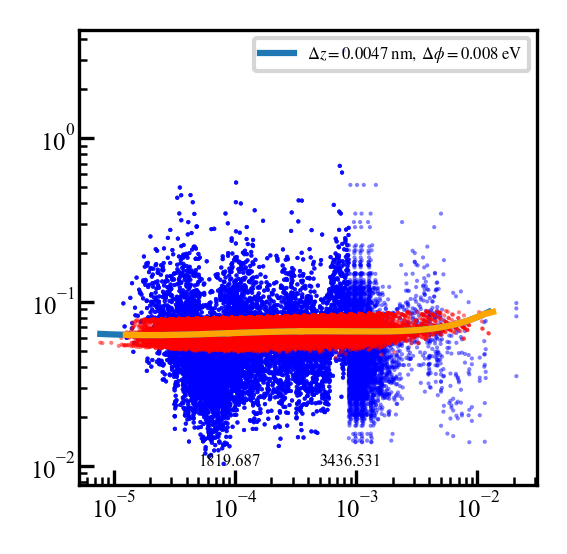

In [437]:
fig, ax = plt.subplots(1, figsize=utils.cm2inch(5, 5), dpi=300)

dz=0.0047
dP=0.008

relative_noise = calc_noise_sim(sim_data_df=sim_data_mix, dgap=dz, dphi=dP)
        
# calculate the log of the simulation conductance and relative noise as x and y respectively
x = np.log10(sim_data_mix['G [G0]'].to_numpy())
y = np.log10(relative_noise)

# sort by conductance
sorter_arr = np.argsort(x)
x = x[sorter_arr]
y = y[sorter_arr]
# fit degree 5 polynomial to simulated data
p_fit = Polynomial.fit(x=x, y=y, deg=5)

# evaluate fitted polynomial at simulation conductance points
x_fit = sim_data_mix['G [G0]'].to_numpy()[sorter_arr]
y_fit = 10**p_fit(np.log10(x_fit))

# interpolate for the measurement data
x_int_1 = sim_data_mix['G_meas1 [G0]'].to_numpy()
sorter_1 = np.argsort(x_int_1)
x_int_1 = x_int_1[sorter_1]

y_int_1 = np.interp(x_int_1, x_fit, y_fit)
y_meas_1 = sim_data_mix['dG/G_meas1'].to_numpy()

x_int_2 = sim_data_mix['G_meas2 [G0]'].to_numpy()
sorter_2 = np.argsort(x_int_2)
x_int_2 = x_int_2[sorter_2]

y_int_2 = np.interp(x_int_2, x_fit, y_fit)
y_meas_2 = sim_data_mix['dG/G_meas2'].to_numpy()

sq_diff_1 = np.sum((np.log10(y_int_1) - np.log10(y_meas_1))**2)
sq_diff_2 = np.sum((np.log10(y_int_2) - np.log10(y_meas_2))**2)

sqr_diff_all_1[i, j] = sq_diff_1
sqr_diff_all_2[i, j] = sq_diff_2

ax.scatter(x_int_1, y_meas_1, c='blue', alpha=0.5, s=1, edgecolor='None')
#ax.scatter(x_int_2, y_meas_2, c='green', alpha=0.5, s=1, edgecolor='None')
ax.scatter(sim_data_mix['G [G0]'].to_numpy(), relative_noise, c='r', alpha=0.5, s=1, edgecolor='None')
ax.plot(x_fit, y_fit, label=r'$\Delta z = ' + str(np.round(dz, 4)) + r'\;\mathrm{nm},\;' + r'\Delta \phi = ' + str(np.round(dP, 3)) + r'\;\mathrm{eV}$')
# ax[i, j].plot(x_int_1, y_int_1, c='orange')
ax.plot(x_int_2, y_int_2, c='orange')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend(fontsize=4)

ax.text(x=5e-5, y=1e-2, s=str(np.round(sq_diff_1, 3)), fontsize=4)
ax.text(x=5e-4, y=1e-2, s=str(np.round(sq_diff_2, 3)), fontsize=4)

In [431]:
sim_data_mix[sim_data_mix['date']=='22_02_03']

,Trace,Fit Trace,R [Ohm],z -Gap [nm],Phi - Barrier [eV],dR/dz,dR/dPhi,G_meas1 [G0],dG/G_meas1,G_meas2 [G0],...,date,dG/G_sim_gap,dG/G_sim_phi,dG/G_sim_gap_phi,dG/G_sim_1,dG/G_sim_2,dG/G_sim_3,dG/G_sim_4,dG/G_sim_5,dG/G_sim_6
0,19515,'1_IV_trace_19515_push_pl',123337740.0,0.43,1.38,1.690506e+18,1.103075e+27,0.000104,0.098067,0.000115,...,22_02_03,0.041119,0.047222,0.051503,0.067176,0.046657,0.053474,0.052104,0.064351,0.047993
4413,19515,'2_IV_trace_19515_push_pl',115852820.0,0.41,1.54,1.670889e+18,9.379184e+26,0.000104,0.098067,0.000115,...,22_02_03,0.043268,0.042746,0.047908,0.070682,0.048709,0.056263,0.054821,0.067360,0.050495
8826,19515,'3_IV_trace_19515_push_pl',118121180.0,0.43,1.35,1.605310e+18,1.066052e+27,0.000104,0.098067,0.000115,...,22_02_03,0.040771,0.047652,0.051830,0.066608,0.046312,0.053022,0.051664,0.063852,0.047588
13239,19515,'4_IV_trace_19515_push_pl',115108080.0,0.48,0.96,1.354317e+18,1.531600e+27,0.000104,0.098067,0.000115,...,22_02_03,0.035297,0.070254,0.072437,0.057691,0.042398,0.045935,0.044760,0.057413,0.041235
1,19529,'1_IV_trace_19529_push_pl',172076560.0,0.53,0.88,1.912228e+18,2.374670e+27,0.000081,0.070921,0.000086,...,22_02_03,0.033338,0.072864,0.074747,0.054497,0.040704,0.043396,0.042286,0.054845,0.038957
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24874,49083,'4_IV_trace_49083_push_pl',93806128.0,0.35,2.20,1.595239e+18,5.499750e+26,0.000113,0.088571,0.000294,...,22_02_03,0.051017,0.030956,0.040112,0.083333,0.056618,0.066329,0.064628,0.078681,0.059527
19457,49088,'1_IV_trace_49088_push_pl',195853160.0,0.47,1.33,2.604451e+18,1.969822e+27,0.000067,0.066466,0.000087,...,22_02_03,0.039894,0.053104,0.056727,0.065180,0.045733,0.051887,0.050558,0.062862,0.046571
21263,49088,'2_IV_trace_49088_push_pl',201705620.0,0.50,1.13,2.508884e+18,2.352905e+27,0.000067,0.066466,0.000087,...,22_02_03,0.037315,0.061591,0.064355,0.060976,0.043678,0.048545,0.047303,0.059631,0.043574
23069,49088,'3_IV_trace_49088_push_pl',224151430.0,0.52,1.06,2.703747e+18,2.815920e+27,0.000067,0.066466,0.000087,...,22_02_03,0.036186,0.066330,0.068754,0.059139,0.042930,0.047085,0.045880,0.058360,0.042265


In [433]:
sim_data_mix[sim_data_mix['date']=='22_02_03'].shape[0]/4

6219.0

Text(0.0005, 0.01, '3091.875')

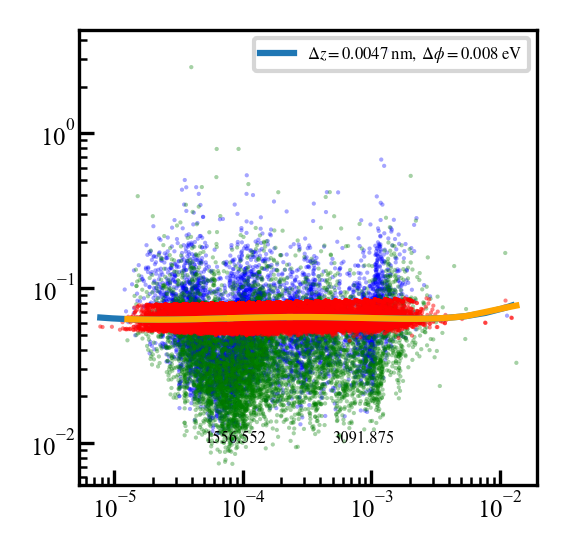

In [427]:
fig, ax = plt.subplots(1, figsize=utils.cm2inch(5, 5), dpi=300)

dz=0.0047
dP=0.008


sim_data_22_02_03 = sim_data_mix[sim_data_mix['date']=='22_02_03']
relative_noise = calc_noise_sim(sim_data_df=sim_data_22_02_03, dgap=dz, dphi=dP)
        
# calculate the log of the simulation conductance and relative noise as x and y respectively
x = np.log10(sim_data_22_02_03['G [G0]'].to_numpy())
y = np.log10(relative_noise)

# sort by conductance
sorter_arr = np.argsort(x)
x = x[sorter_arr]
y = y[sorter_arr]
# fit degree 5 polynomial to simulated data
p_fit = Polynomial.fit(x=x, y=y, deg=5)

# evaluate fitted polynomial at simulation conductance points
x_fit = sim_data_22_02_03['G [G0]'].to_numpy()[sorter_arr]
y_fit = 10**p_fit(np.log10(x_fit))

# interpolate for the measurement data
x_int_1 = sim_data_22_02_03['G_meas1 [G0]'].to_numpy()
sorter_1 = np.argsort(x_int_1)
x_int_1 = x_int_1[sorter_1]

y_int_1 = np.interp(x_int_1, x_fit, y_fit)
y_meas_1 = sim_data_22_02_03['dG/G_meas1'].to_numpy()

x_int_2 = sim_data_22_02_03['G_meas2 [G0]'].to_numpy()
sorter_2 = np.argsort(x_int_2)
x_int_2 = x_int_2[sorter_2]

y_int_2 = np.interp(x_int_2, x_fit, y_fit)
y_meas_2 = sim_data_22_02_03['dG/G_meas2'].to_numpy()

sq_diff_1 = np.sum((np.log10(y_int_1) - np.log10(y_meas_1))**2)
sq_diff_2 = np.sum((np.log10(y_int_2) - np.log10(y_meas_2))**2)

sqr_diff_all_1[i, j] = sq_diff_1
sqr_diff_all_2[i, j] = sq_diff_2

ax.scatter(x_int_1, y_meas_1, c='blue', alpha=0.1, s=1, edgecolor='None')
ax.scatter(x_int_2, y_meas_2, c='green', alpha=0.1, s=1, edgecolor='None')
ax.scatter(sim_data_22_02_03['G [G0]'].to_numpy(), relative_noise, c='r', alpha=0.5, s=1, edgecolor='None')
ax.plot(x_fit, y_fit, label=r'$\Delta z = ' + str(np.round(dz, 4)) + r'\;\mathrm{nm},\;' + r'\Delta \phi = ' + str(np.round(dP, 3)) + r'\;\mathrm{eV}$')
# ax[i, j].plot(x_int_1, y_int_1, c='orange')
ax.plot(x_int_2, y_int_2, c='orange')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend(fontsize=4)

ax.text(x=5e-5, y=1e-2, s=str(np.round(sq_diff_1, 3)), fontsize=4)
ax.text(x=5e-4, y=1e-2, s=str(np.round(sq_diff_2, 3)), fontsize=4)

In [154]:
sim_data_mix

,Trace,Fit Trace,R [Ohm],z -Gap [nm],Phi - Barrier [eV],dR/dz,dR/dPhi,G_meas1 [G0],dG/G_meas1,G_meas2 [G0],dG/G_meas2,Part,G [G0],date,dG/G_sim_gap,dG/G_sim_phi,dG/G_sim_gap_phi
0,19515,'1_IV_trace_19515_push_pl',1.233377e+08,0.43,1.38,1.690506e+18,1.103075e+27,0.000104,0.098067,0.000115,0.046079,1,0.000105,22_02_03,0.041119,0.047222,0.051503
4413,19515,'2_IV_trace_19515_push_pl',1.158528e+08,0.41,1.54,1.670889e+18,9.379184e+26,0.000104,0.098067,0.000115,0.046079,2,0.000111,22_02_03,0.043268,0.042746,0.047908
8826,19515,'3_IV_trace_19515_push_pl',1.181212e+08,0.43,1.35,1.605310e+18,1.066052e+27,0.000104,0.098067,0.000115,0.046079,3,0.000109,22_02_03,0.040771,0.047652,0.051830
13239,19515,'4_IV_trace_19515_push_pl',1.151081e+08,0.48,0.96,1.354317e+18,1.531600e+27,0.000104,0.098067,0.000115,0.046079,4,0.000112,22_02_03,0.035297,0.070254,0.072437
1,19529,'1_IV_trace_19529_push_pl',1.720766e+08,0.53,0.88,1.912228e+18,2.374670e+27,0.000081,0.070921,0.000086,0.089175,1,0.000075,22_02_03,0.033338,0.072864,0.074747
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4491,34168,'4_IV_trace_34168_push_pl',1.969823e+06,0.16,1.03,2.919545e+16,6.096039e+24,0.009005,0.051511,0.004081,0.036337,4,0.006549,22_03_23,0.044464,0.016340,0.027591
4492,34173,'4_IV_trace_34173_push_pl',6.294077e+06,0.23,1.24,9.299089e+16,2.855777e+25,0.001617,0.081721,0.001663,0.054082,4,0.002050,22_03_23,0.044323,0.023957,0.032635
4493,34175,'4_IV_trace_34175_push_pl',2.633340e+06,0.19,0.81,3.569414e+16,1.069254e+25,0.006712,0.098494,0.004635,0.025815,4,0.004899,22_03_23,0.040664,0.021439,0.029547
4494,34185,'4_IV_trace_34185_push_pl',1.912974e+06,0.15,1.29,3.031204e+16,5.297626e+24,0.006658,0.091355,0.007541,0.065379,4,0.006743,22_03_23,0.047537,0.014622,0.027906


In [307]:
sim_data_mix['dG/G_sim_1'] = calc_noise_sim(sim_data_mix, dgap=0.0049, dphi=0.001)
sim_data_mix['dG/G_sim_2'] = calc_noise_sim(sim_data_mix, dgap=0.0033, dphi=0.008)

sim_data_mix['dG/G_sim_3'] = calc_noise_sim(sim_data_mix, dgap=0.0039, dphi=0.001)
sim_data_mix['dG/G_sim_4'] = calc_noise_sim(sim_data_mix, dgap=0.0038, dphi=0.001)

sim_data_mix['dG/G_sim_5'] = calc_noise_sim(sim_data_mix, dgap=0.0046, dphi=0.009)
sim_data_mix['dG/G_sim_6'] = calc_noise_sim(sim_data_mix, dgap=0.0035, dphi=0.001)

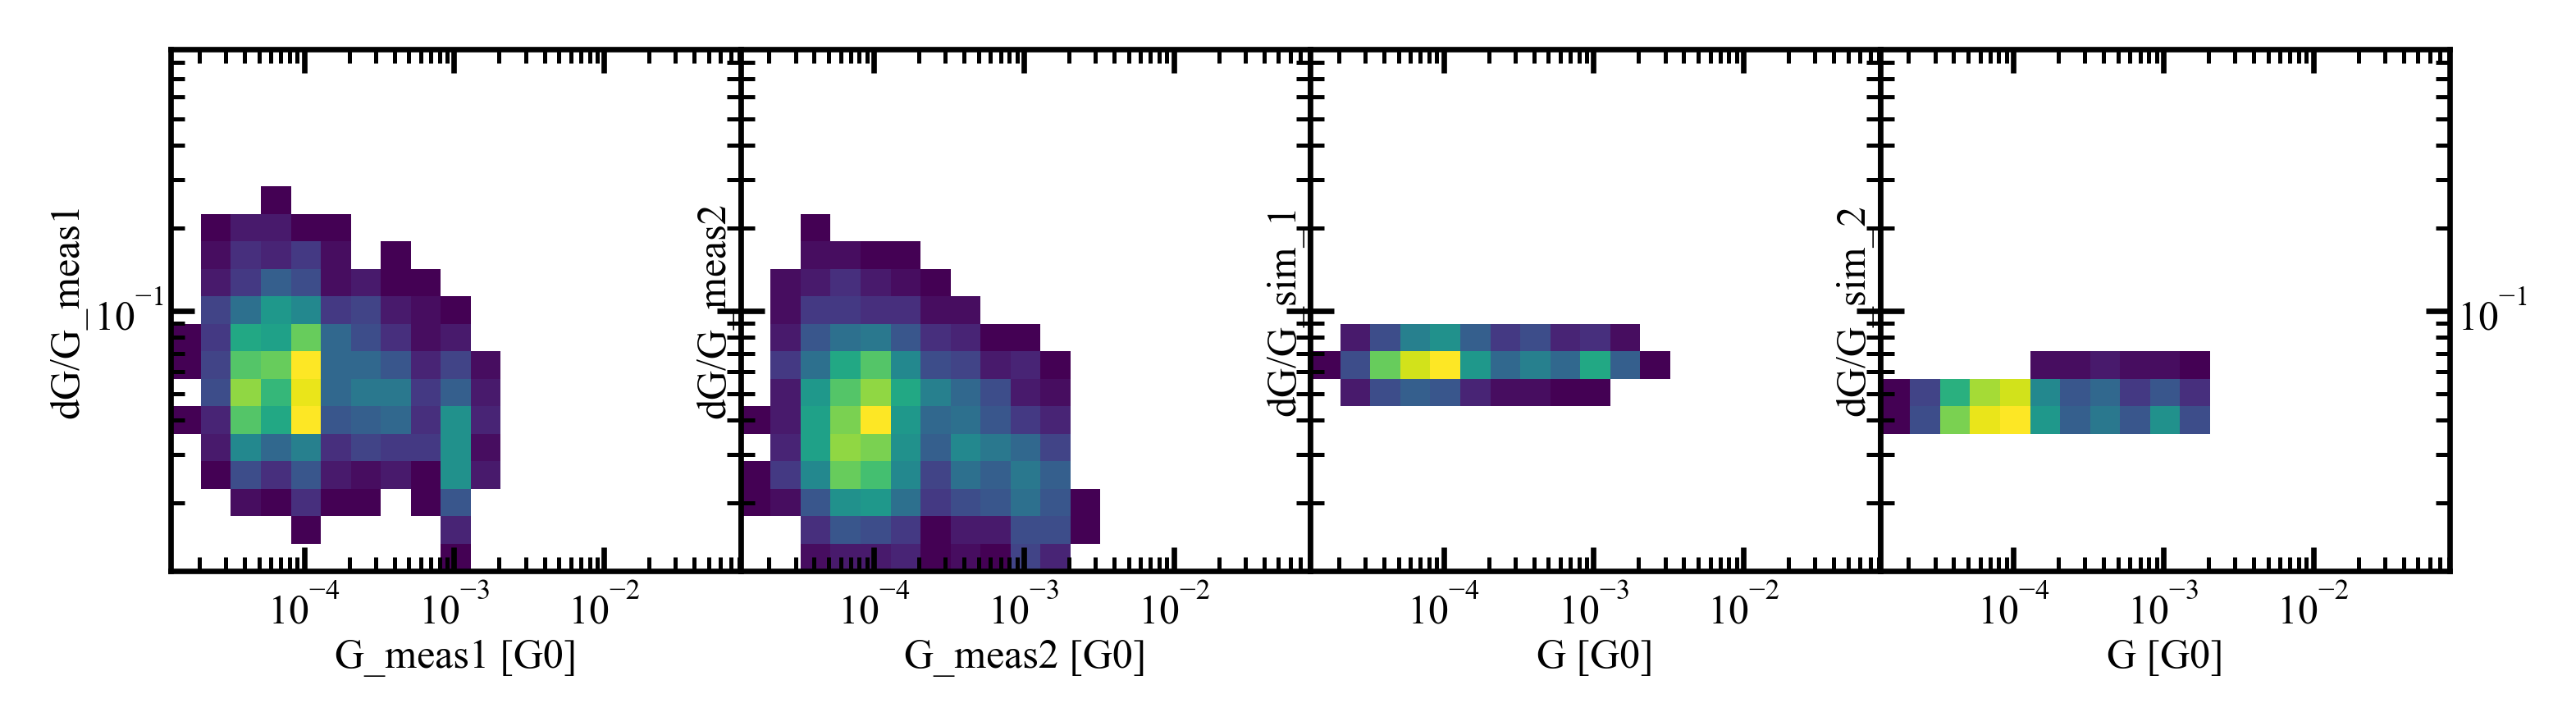

In [309]:
fig, ax = plot_2D_rel_noise_hists(sim_data_mix[sim_data_mix['date'] == '22_02_03'],
                                  x_vars=('G_meas1 [G0]', 'G_meas2 [G0]', 'G [G0]', 'G [G0]'),
                                  y_vars=('dG/G_meas1', 'dG/G_meas2', 'dG/G_sim_1', 'dG/G_sim_2'),
                                  xrange=(1e-5, 1e-1), yrange=(1e-2, 1), xbins_num=20, ybins_num=20, cmap=my_cmap_blues, figsize=utils.cm2inch(14, 3.5))

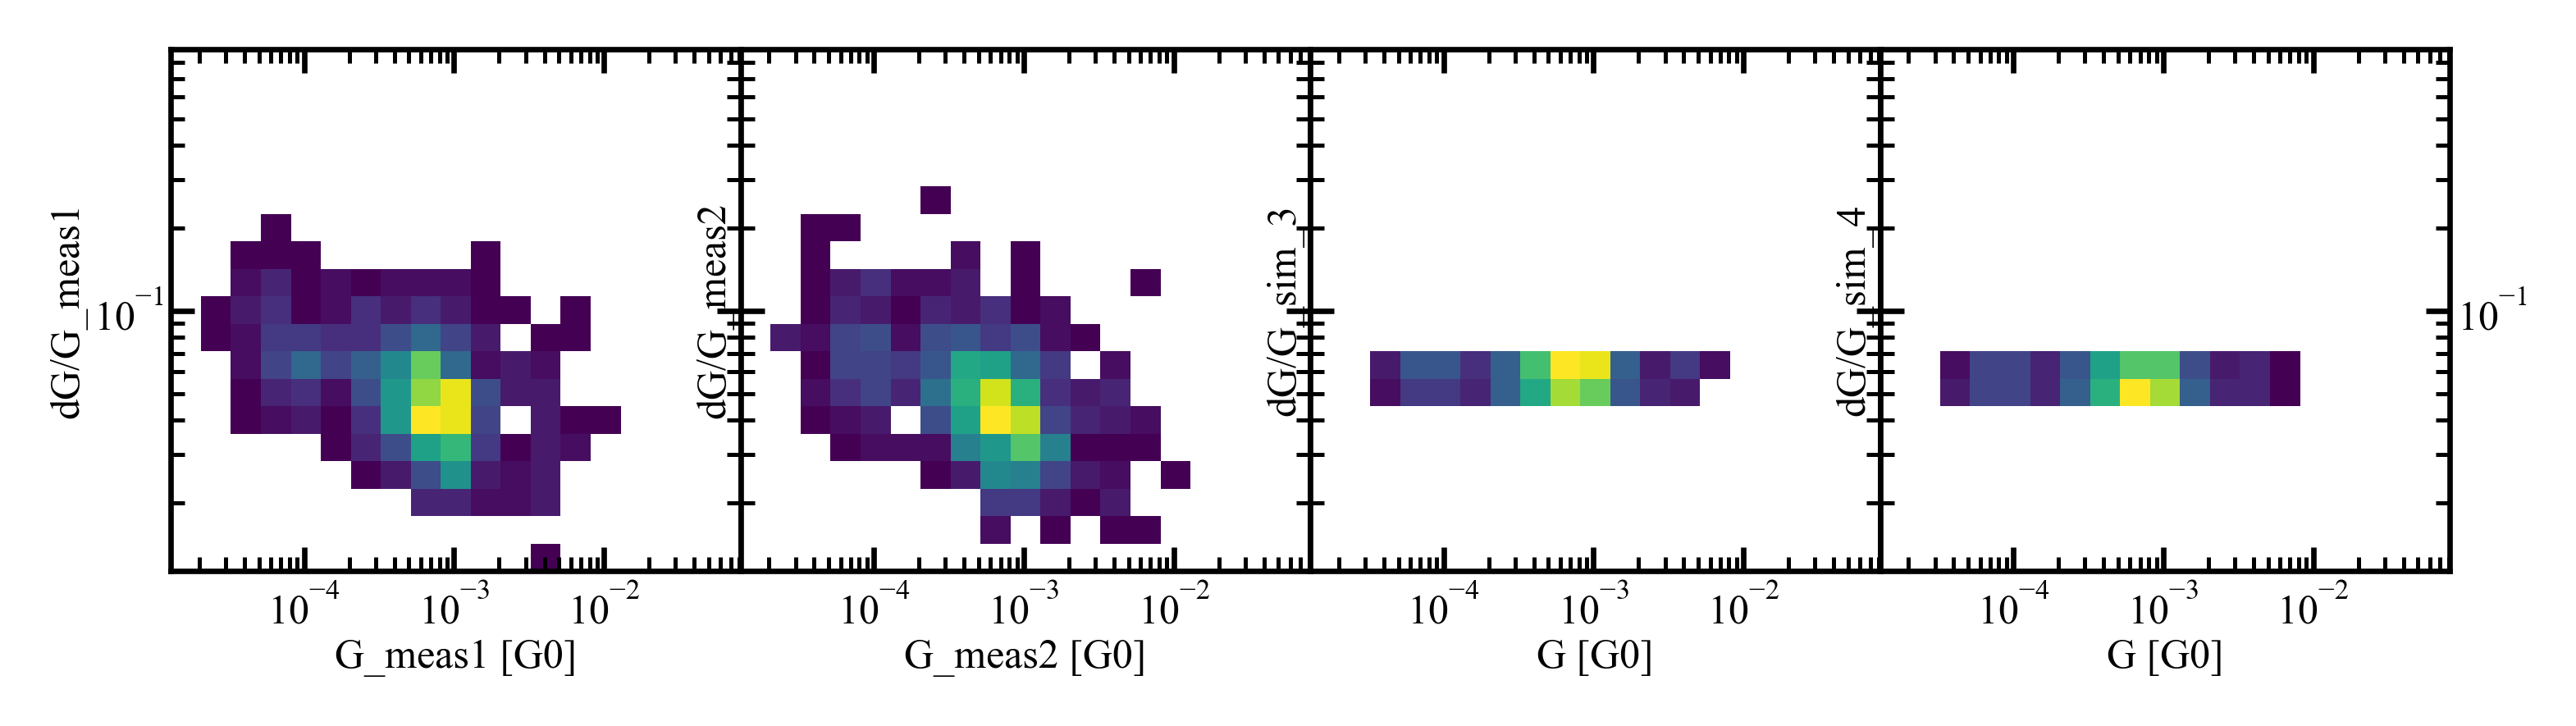

In [310]:
fig, ax = plot_2D_rel_noise_hists(sim_data_mix[sim_data_mix['date'] == '22_03_23'],
                                  x_vars=('G_meas1 [G0]', 'G_meas2 [G0]', 'G [G0]', 'G [G0]'),
                                  y_vars=('dG/G_meas1', 'dG/G_meas2', 'dG/G_sim_3', 'dG/G_sim_4'),
                                  xrange=(1e-5, 1e-1), yrange=(1e-2, 1), xbins_num=20, ybins_num=20, cmap=my_cmap_blues, figsize=utils.cm2inch(14, 3.5))

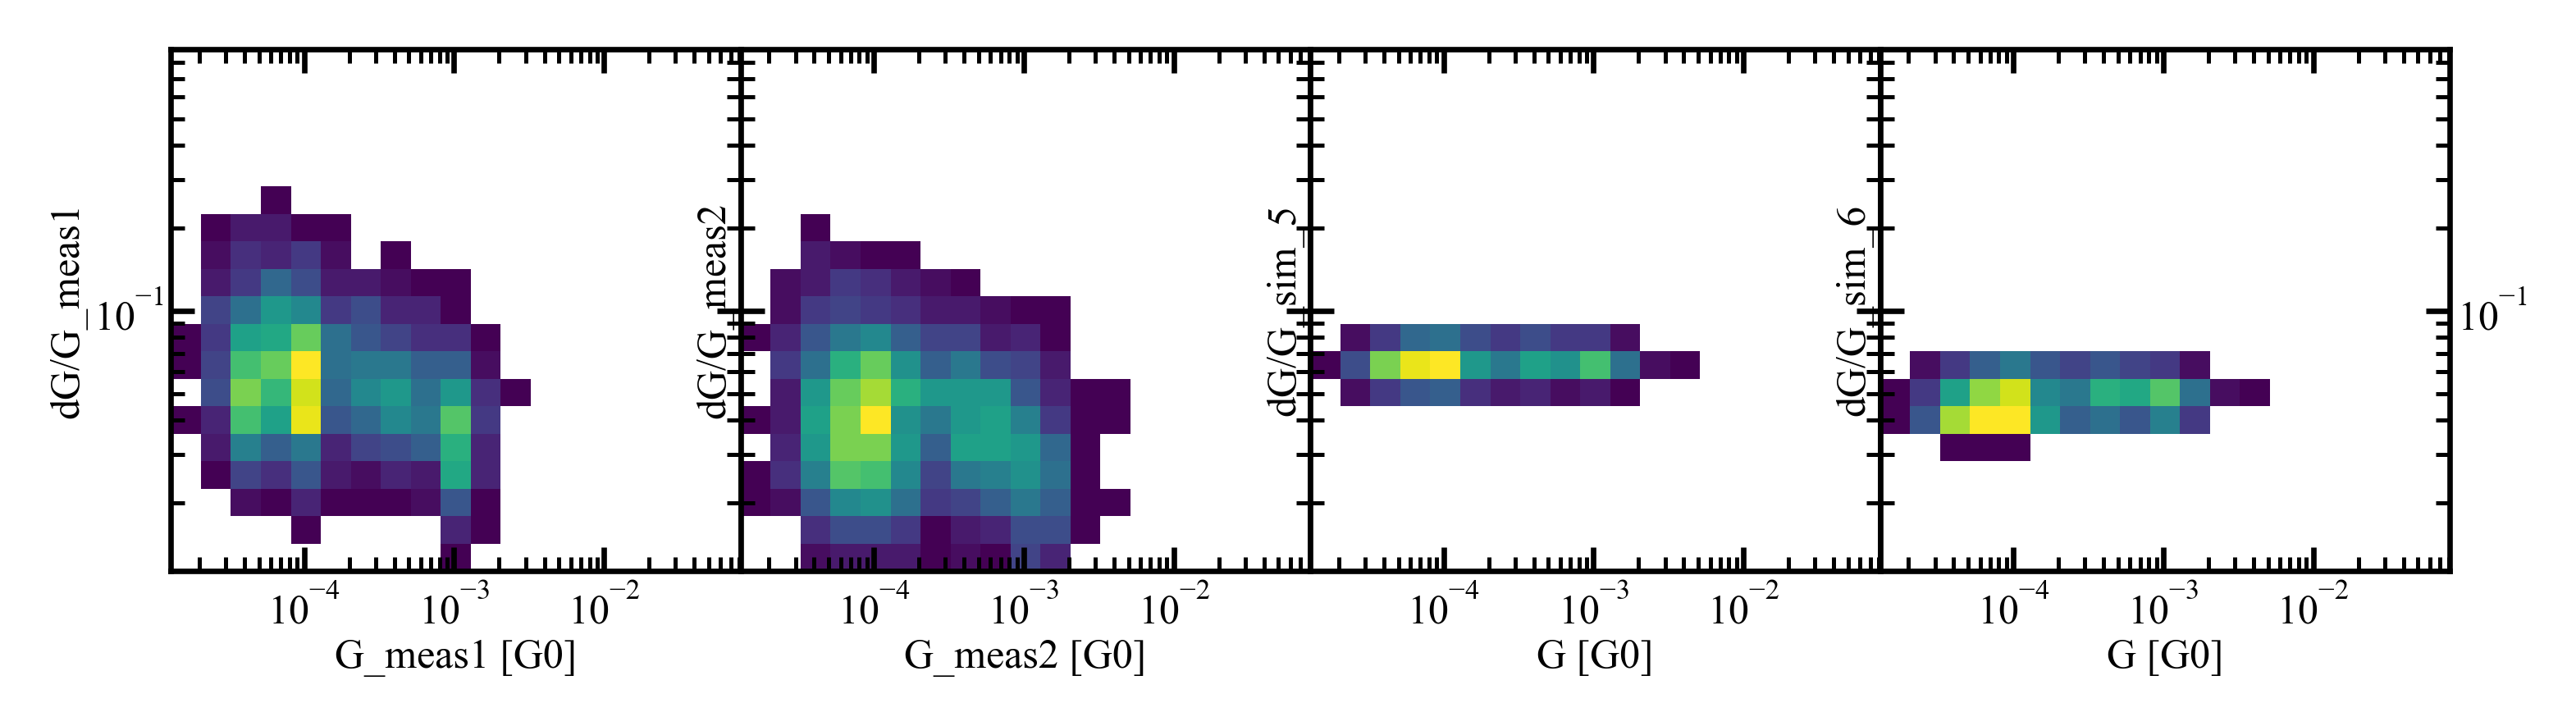

In [311]:
fig, ax = plot_2D_rel_noise_hists(sim_data_mix,
                                  x_vars=('G_meas1 [G0]', 'G_meas2 [G0]', 'G [G0]', 'G [G0]'),
                                  y_vars=('dG/G_meas1', 'dG/G_meas2', 'dG/G_sim_5', 'dG/G_sim_6'),
                                  xrange=(1e-5, 1e-1), yrange=(1e-2, 1), xbins_num=20, ybins_num=20, cmap=my_cmap_blues, figsize=utils.cm2inch(14, 3.5))

***************************************************

# 22_02_03 data only

In [26]:
def igor_gaussian_fun(x, y0, A, x0, width):
    
    """
    x0: mean
    width/2: variance
    A: amplitude
    y0: vertical offset
    """
    
    return y0 + A * np.exp( -1 * ((x - x0)/width)**2 )

In [224]:
sim_data_22_02_03 = sim_data_mix[sim_data_mix['date']=='22_02_03']

In [231]:
sim_data_22_02_03 = sim_data_22_02_03[sim_data_22_02_03['Phi - Barrier [eV]'] < 2]

In [232]:
sim_data_22_02_03

,Trace,Fit Trace,R [Ohm],z -Gap [nm],Phi - Barrier [eV],dR/dz,dR/dPhi,G_meas1 [G0],dG/G_meas1,G_meas2 [G0],dG/G_meas2,Part,G [G0],date,dG/G_sim_gap,dG/G_sim_phi,dG/G_sim_gap_phi
0,19515,'1_IV_trace_19515_push_pl',123337740.0,0.43,1.38,1.690506e+18,1.103075e+27,0.000104,0.098067,0.000115,0.046079,1,0.000105,22_02_03,0.041119,0.047222,0.051503
4413,19515,'2_IV_trace_19515_push_pl',115852820.0,0.41,1.54,1.670889e+18,9.379184e+26,0.000104,0.098067,0.000115,0.046079,2,0.000111,22_02_03,0.043268,0.042746,0.047908
8826,19515,'3_IV_trace_19515_push_pl',118121180.0,0.43,1.35,1.605310e+18,1.066052e+27,0.000104,0.098067,0.000115,0.046079,3,0.000109,22_02_03,0.040771,0.047652,0.051830
13239,19515,'4_IV_trace_19515_push_pl',115108080.0,0.48,0.96,1.354317e+18,1.531600e+27,0.000104,0.098067,0.000115,0.046079,4,0.000112,22_02_03,0.035297,0.070254,0.072437
1,19529,'1_IV_trace_19529_push_pl',172076560.0,0.53,0.88,1.912228e+18,2.374670e+27,0.000081,0.070921,0.000086,0.089175,1,0.000075,22_02_03,0.033338,0.072864,0.074747
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23068,49083,'3_IV_trace_49083_push_pl',104710350.0,0.43,1.27,1.394623e+18,9.722801e+26,0.000113,0.088571,0.000294,0.168821,3,0.000123,22_02_03,0.039957,0.049027,0.052941
19457,49088,'1_IV_trace_49088_push_pl',195853160.0,0.47,1.33,2.604451e+18,1.969822e+27,0.000067,0.066466,0.000087,0.032976,1,0.000066,22_02_03,0.039894,0.053104,0.056727
21263,49088,'2_IV_trace_49088_push_pl',201705620.0,0.50,1.13,2.508884e+18,2.352905e+27,0.000067,0.066466,0.000087,0.032976,2,0.000064,22_02_03,0.037315,0.061591,0.064355
23069,49088,'3_IV_trace_49088_push_pl',224151430.0,0.52,1.06,2.703747e+18,2.815920e+27,0.000067,0.066466,0.000087,0.032976,3,0.000058,22_02_03,0.036186,0.066330,0.068754


In [233]:
21168/4

5292.0

In [234]:
sim_data_22_02_03['Phi - Barrier [eV]'].max()

1.99

In [235]:
meas_data_22_02_03 = sim_data_22_02_03.groupby('Trace')[['G_meas1 [G0]', 'dG/G_meas1', 'G_meas2 [G0]', 'dG/G_meas2']].mean()

In [236]:
meas_data_22_02_03

,G_meas1 [G0],dG/G_meas1,G_meas2 [G0],dG/G_meas2
Trace,,,,
19515,0.000104,0.098067,0.000115,0.046079
19529,0.000081,0.070921,0.000086,0.089175
19535,0.000098,0.060375,0.000077,0.131780
19536,0.000123,0.105979,0.000136,0.049800
19568,0.000111,0.069067,0.000122,0.078762
...,...,...,...,...
49057,0.000080,0.283386,0.000102,0.138958
49067,0.000160,0.059936,0.000397,0.046973
49072,0.000086,0.104733,0.000123,0.073369


## Simulate the relative noise with:
$\Delta z = (0, 5.1)\;\mathrm{pm}$

$\Delta \phi = (1, 51)\;\mathrm{meV}$

In [241]:
dFluct = np.arange(start=0, stop=0.0051, step=0.0001) ## stop/3
PhiFluct = np.arange(start=0.001, stop=0.051, step=0.001) ## stop/3

## Calculating 2D relative noise histograms for simulations

In [242]:
def calc_bins(middle: np.ndarray, log_scale=True):
    if log_scale:
        bin_width = np.mean(np.diff(np.log10(middle)))
        return np.append(10**(np.log10(middle)-bin_width/2), 10**(np.log10(middle[-1])+bin_width/2))
    else:
        bin_width = np.mean(np.diff(middle))
        return np.append(middle-bin_width/2, middle[-1]+bin_width/2)
    
def calc_hist_2d_new(x: np.ndarray, y: np.ndarray, xbins: np.ndarray, ybins: np.ndarray):
    h, xedges, yedges = np.histogram2d(x, y, bins=[xbins, ybins])
    x_mesh, y_mesh = np.meshgrid(xedges, yedges)

    return x_mesh, y_mesh, h.T

In [243]:
sim_hist_2d_all = []


for i, dz in enumerate(tqdm(dFluct)):
    for j, dP in enumerate(PhiFluct):
        relative_noise = calc_noise_sim(sim_data_df=sim_data_22_02_03, dgap=dz, dphi=dP)
        
#         x_mesh, y_mesh, sim_hist_2d = utils.calc_hist_2d_single(x=sim_data_22_02_03['G [G0]'],
#                                                                 y=relative_noise,
#                                                                 xrange=(1e-5, 1e-2), log_scale_x=True,
#                                                                 yrange=(1e-3, 1), log_scale_y=True,
#                                                                 num_bins=(5, 20),
#                                                                 bin_mode_x='decade',
#                                                                 bin_mode_y='decade')
        
        x_mesh, y_mesh, sim_hist_2d = calc_hist_2d_new(x=sim_data_22_02_03['G [G0]'],
                                                       y=relative_noise,
                                                       xbins=calc_bins(np.logspace(-5, -2, 15)),
                                                       ybins=calc_bins(np.logspace(-3, 0, 60)))
        
        sim_hist_2d_all.append(sim_hist_2d)
        
sim_hist_2d_all = np.array(sim_hist_2d_all)
x_num, y_num = sim_hist_2d_all.shape[1:]

print(sim_hist_2d_all.reshape((i+1, j+1, x_num, y_num)).shape)

sim_hist_2d_all = sim_hist_2d_all.reshape((i+1, j+1, x_num, y_num))
print(sim_hist_2d_all.shape)

  0%|          | 0/51 [00:00<?, ?it/s]

(51, 50, 60, 15)
(51, 50, 60, 15)


In [244]:
print(sim_hist_2d_all.shape)

(51, 50, 60, 15)


(6,) (5,)


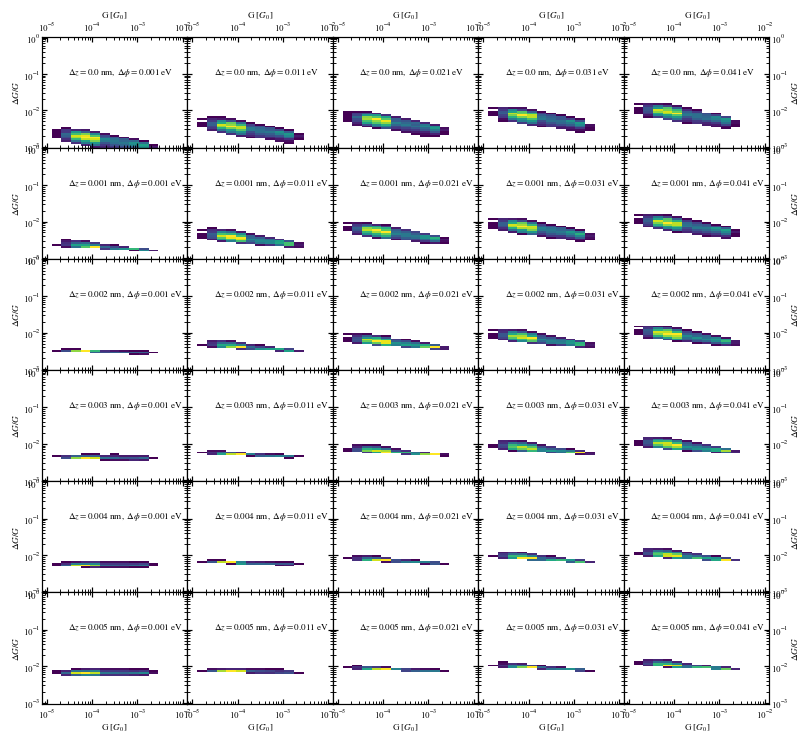

In [245]:
fig = plt.figure(figsize=utils.cm2inch(20, 20), dpi=110)

sample_dFluct = dFluct[::10]
sample_PhiFluct = PhiFluct[::10]

gs = plt.GridSpec(sample_dFluct.shape[0], sample_PhiFluct.shape[0], figure=fig,
                  left=0.08, right=0.92, top=0.9, bottom=0.13,
                  hspace=0.0, wspace=0.0)

print(sample_dFluct.shape, sample_PhiFluct.shape)

ax = np.array([fig.add_subplot(gs[i, j]) for i in range(sample_dFluct.shape[0]) for j in range(sample_PhiFluct.shape[0])]).reshape((sample_dFluct.shape[0], sample_PhiFluct.shape[0]))

for i in range(sample_dFluct.shape[0]):
    for j in range(sample_PhiFluct.shape[0]):
        #ax[i, j].text()
        ax[i, j].set_xscale('log')
        ax[i, j].set_yscale('log')
        ax[i, j].pcolormesh(x_mesh, y_mesh, sim_hist_2d_all[i, j, :, :], cmap=my_cmap_blues, vmin=0)#, vmax=0.5*max(sim_hist_2d_all[i, j, :, :].flatten()))
        
        ax[i, j].xaxis.set_major_locator(ticker.LogLocator(base=10.0, subs=(1.0,), numticks=9))
        ax[i, j].xaxis.set_minor_locator(ticker.LogLocator(base=10.0, subs=np.arange(0, 1, 0.1), numticks=9))
        ax[i, j].xaxis.set_minor_formatter(ticker.NullFormatter())
        
        ax[i, j].tick_params(which='both',
                                 left=True, right=True, top=True, bottom=True,
                                 labelleft=(j==0), labelright=(j == sample_PhiFluct.shape[0]-1), labeltop=(i==0), labelbottom=(i==sample_dFluct.shape[0]-1))
        
        ax[i, j].text(x=3e-5, y=1e-1, s=r'$\Delta z =' + str(sample_dFluct[i]) + r'\;\mathrm{nm},\; \Delta \phi =' + str(sample_PhiFluct[j]) + r'\;\mathrm{eV}$', fontsize=6)
        
        if i == 0:
            ax[i, j].set_xlabel(r'G $[G_0]$')
            ax[i, j].xaxis.set_label_position('top')
        if i==sample_dFluct.shape[0]-1:
            ax[i, j].set_xlabel(r'G $[G_0]$')
            
        if j == 0:
            ax[i, j].set_ylabel(r'$\Delta G / G$')
        if j==sample_PhiFluct.shape[0]-1:
            ax[i, j].yaxis.set_label_position('right')
            ax[i, j].set_ylabel(r'$\Delta G / G$')

In [246]:
print(x_mesh.shape)
print(y_mesh.shape)

(61, 16)
(61, 16)


## Calculating 2D histograms of measurement data

In [247]:
# print(np.diff(np.linspace(-5, -2, 15)))
# print(np.diff(np.log10(np.logspace(-5, -2, 15))))
h, xedges, yedges = np.histogram2d(meas_data_22_02_03['G_meas1 [G0]'],
                                   meas_data_22_02_03['dG/G_meas1'],
                                   bins=[calc_bins(np.logspace(-5, -2, 15)), calc_bins(np.logspace(-3, 0, 30))])

# print('------------------------------')

# print(np.logspace(-5, -2, 15))

bin_width = np.mean(np.diff(np.log10(np.logspace(-5, -2, 15))))
# print(bin_width)
# print(xedges)

In [249]:
# test simulation data, calculated by Zoli in IgorPro, with arbitrarily selected simulation parameters dz, dPhi (what were they exactly?)
# goal is to compare the parameters aquired by the the minimum search of the sq difference in python with these results 
igor_test = np.loadtxt(home_folder_1.joinpath('igor_test_data.txt'), skiprows=2)

In [150]:
# ['G_meas1 [G0]', 'dG/G_meas1', 'G_meas2 [G0]', 'dG/G_meas2']

# x_mesh_meas, y_mesh_meas, meas_hist_2d_1 = utils.calc_hist_2d_single(x=meas_data_22_02_03['G_meas1 [G0]'],
#                                                                      y=meas_data_22_02_03['dG/G_meas1'],
#                                                                      xrange=(1e-5, 1e-2), log_scale_x=True,
#                                                                      yrange=(1e-3, 1), log_scale_y=True,
#                                                                      num_bins=(5, 10),
#                                                                      bin_mode_x='decade',
#                                                                      bin_mode_y='decade')
        
# x_mesh_meas, y_mesh_meas, meas_hist_2d_2 = utils.calc_hist_2d_single(x=meas_data_22_02_03['G_meas2 [G0]'],
#                                                                      y=meas_data_22_02_03['dG/G_meas2'],
#                                                                      xrange=(1e-5, 1e-2), log_scale_x=True,
#                                                                      yrange=(1e-3, 1), log_scale_y=True,
#                                                                      num_bins=(5, 10),
#                                                                      bin_mode_x='decade',
#                                                                      bin_mode_y='decade')

x_mesh_meas, y_mesh_meas, meas_hist_2d_1 = calc_hist_2d_new(x=meas_data_22_02_03['G_meas1 [G0]'],
                                                            y=meas_data_22_02_03['dG/G_meas1'],
                                                            xbins=calc_bins(np.logspace(-5, -2, 15)),
                                                            ybins=calc_bins(np.logspace(-3, 0, 30)))

x_mesh_meas, y_mesh_meas, meas_hist_2d_2 = calc_hist_2d_new(x=meas_data_22_02_03['G_meas2 [G0]'],
                                                            y=meas_data_22_02_03['dG/G_meas2'],
                                                            xbins=calc_bins(np.logspace(-5, -2, 15)),
                                                            ybins=calc_bins(np.logspace(-3, 0, 30)))

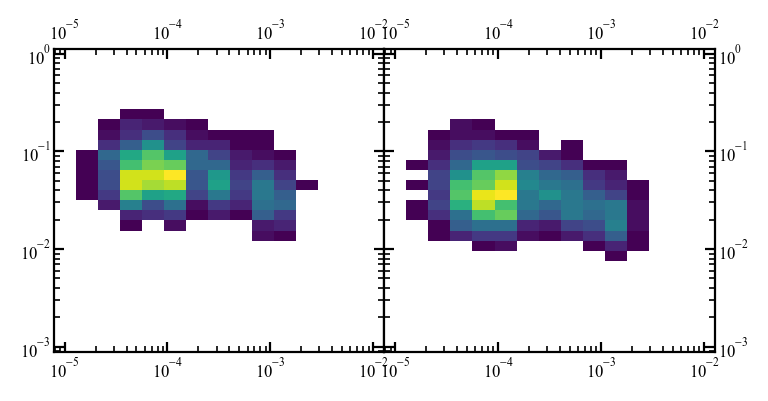

In [151]:
fig = plt.figure(figsize=utils.cm2inch(10, 5), dpi=200)

gs = plt.GridSpec(1, 2, figure=fig,
                  left=0.08, right=0.92, top=0.9, bottom=0.13,
                  hspace=0.0, wspace=0.0)

ax = np.array([fig.add_subplot(gs[i]) for i in range(2)])

for i, hist_2d in enumerate((meas_hist_2d_1, meas_hist_2d_2)):
        ax[i].set_xscale('log')
        ax[i].set_yscale('log')
        ax[i].pcolormesh(x_mesh_meas, y_mesh_meas, hist_2d, cmap=my_cmap_blues, vmin=0)
        
        ax[i].xaxis.set_major_locator(ticker.LogLocator(base=10.0, subs=(1.0,), numticks=9))
        ax[i].xaxis.set_minor_locator(ticker.LogLocator(base=10.0, subs=np.arange(0, 1, 0.1), numticks=9))
        ax[i].xaxis.set_minor_formatter(ticker.NullFormatter())
        
        ax[i].tick_params(which='both',
                          left=True, right=True, top=True, bottom=True,
                          labelleft=(i==0), labelright=(i==1), labeltop=True, labelbottom=True)

## Normalizing histograms using Gaussian fitting and connecting the maximum locations

In [152]:
def fit_gaussian_to_slice(y_mesh, hist_2d_single):
    popts = []
    popts_norm = []
    perrs = []

    hist_2d_gauss = []
    hist_2d_gauss_norm = []
    
    def nan_arr(to_shape: Union[int, Tuple[int, ...]]):
        a = np.zeros(to_shape)
        a[:] = np.nan
        
        return a
    
    for i in range(hist_2d_single.shape[-1]):
        ymiddle = np.log10(y_mesh[:-1, 0] + np.diff(y_mesh[:, 0])/2)# yedges[:-1] + np.diff(yedges)/2
    
        max_val = max(hist_2d_single[:, i])
        max_val_at = ymiddle[hist_2d_single[:, i] == max_val][0]
        
        
        if all(hist_2d_single[:, i] == 0):
            hist_2d_gauss.append(np.zeros_like(ymiddle))
            hist_2d_gauss_norm.append(np.zeros_like(ymiddle))
            popts.append(nan_arr(4))
            popts_norm.append(nan_arr(4))
            perrs.append(nan_arr(4))
        else:
            try:
                popt, pcov = scipy.optimize.curve_fit(igor_gaussian_fun, ymiddle, hist_2d_single[:, i],
                                                      p0=(1e-10, max_val, max_val_at, 1))
                perr = np.sqrt(np.diag(pcov))

                popts.append(popt)
                popts_norm.append(np.append(np.array([0, 1]), popt[2:]))
                perrs.append(perr)

                hist_2d_gauss.append(igor_gaussian_fun(ymiddle, *popts[-1]))
                hist_2d_gauss_norm.append(igor_gaussian_fun(ymiddle, *popts_norm[-1]))
            except RuntimeError:
                try:
                    popt, pcov = scipy.optimize.curve_fit(igor_gaussian_fun, ymiddle, hist_2d_single[:, i],
                                                          p0=(1e-10, max_val, max_val_at, 0.01))
                    perr = np.sqrt(np.diag(pcov))

                    popts.append(popt)
                    popts_norm.append(np.append(np.array([0, 1]), popt[2:]))
                    perrs.append(perr)

                    hist_2d_gauss.append(igor_gaussian_fun(ymiddle, *popts[-1]))
                    hist_2d_gauss_norm.append(igor_gaussian_fun(ymiddle, *popts_norm[-1]))
                except RuntimeError:
                    hist_2d_gauss.append(np.zeros_like(ymiddle))
                    hist_2d_gauss_norm.append(np.zeros_like(ymiddle))
                    popts.append(nan_arr(4))
                    popts_norm.append(nan_arr(4))
                    perrs.append(nan_arr(4))
    
    hist_2d_gauss = np.array(hist_2d_gauss).T
    hist_2d_gauss_norm = np.array(hist_2d_gauss_norm).T
    popts = np.array(popts)
    perrs = np.array(perrs)
    
    gaussian_fit_mean = popts[:, 2]
    gaussian_fit_mean_err = perrs[:, 2]
    
    return ymiddle, gaussian_fit_mean, gaussian_fit_mean_err, hist_2d_gauss, hist_2d_gauss_norm

In [630]:
# nr = 5
# nc = 6

# fig, ax = plt.subplots(nrows=nr, ncols=nc, figsize=utils.cm2inch(20, 20), dpi=200)

# # ax.set_yscale('log')

# popts = []
# popts_norm = []
# perrs = []

# gamma_gauss = []
# gamma_gauss_norm = []

# which_z = 5
# which_phi = 30



# for i in range(sim_hist_2d_all.shape[-1]):
    
#     ymiddle = np.log10(y_mesh[:-1, 0] + np.diff(y_mesh[:, 0])/2)# yedges[:-1] + np.diff(yedges)/2
    
#     max_val = max(sim_hist_2d_all[which_z, which_phi, :, i])
#     max_val_at = ymiddle[sim_hist_2d_all[which_z, which_phi, :, i] == max_val][0]
    
#     # print(max_val_at)
    
#     ax[i//nc, i%nc].scatter(ymiddle, sim_hist_2d_all[which_z, which_phi, :, i], s=2)
    
#     if all(sim_hist_2d_all[which_z, which_phi, :, i] == 0):
#         print(i)
#     else:
#         try:
#             popt, pcov = scipy.optimize.curve_fit(igor_gaussian_fun, ymiddle, sim_hist_2d_all[which_z, which_phi, :, i],
#                                                   p0=(1e-10, 0, max_val_at, 1))
#             perr = np.sqrt(np.diag(pcov))

#             popts.append(popt)
#             popts_norm.append(np.append(np.array([0, 1]), popt[2:]))
#             perrs.append(perr)

#             ax[i//nc, i%nc].plot(ymiddle, igor_gaussian_fun(ymiddle, *popts[-1]), c='g')

#             gamma_gauss.append(igor_gaussian_fun(ymiddle, *popts[-1]))
#             gamma_gauss_norm.append(igor_gaussian_fun(ymiddle, *popts_norm[-1]))
#         except RuntimeError:
#             try:
#                 popt, pcov = scipy.optimize.curve_fit(igor_gaussian_fun, ymiddle, sim_hist_2d_all[which_z, which_phi, :, i],
#                                                       p0=(1e-10, 0, max_val_at, 0.01))
#                 perr = np.sqrt(np.diag(pcov))

#                 popts.append(popt)
#                 popts_norm.append(np.append(np.array([0, 1]), popt[2:]))
#                 perrs.append(perr)

#                 ax[i//nc, i%nc].plot(ymiddle, igor_gaussian_fun(ymiddle, *popts[-1]), c='g')

#                 gamma_gauss.append(igor_gaussian_fun(ymiddle, *popts[-1]))
#                 gamma_gauss_norm.append(igor_gaussian_fun(ymiddle, *popts_norm[-1]))
#             except RuntimeError:
#                 ...

In [153]:
warnings.filterwarnings("default")

In [154]:
ymiddle_meas_1, gaussian_fit_mean_meas_1, gaussian_fit_mean_err_meas_1, hist_2d_gauss_meas_1, hist_2d_gauss_norm_meas_1 = \
    fit_gaussian_to_slice(y_mesh_meas, meas_hist_2d_1)

ymiddle_meas_2, gaussian_fit_mean_meas_2, gaussian_fit_mean_err_meas_2, hist_2d_gauss_meas_2, hist_2d_gauss_norm_meas_2 = \
    fit_gaussian_to_slice(y_mesh_meas, meas_hist_2d_2)

D:\mcbj_stmbj\venv\lib\site-packages\scipy\optimize\_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


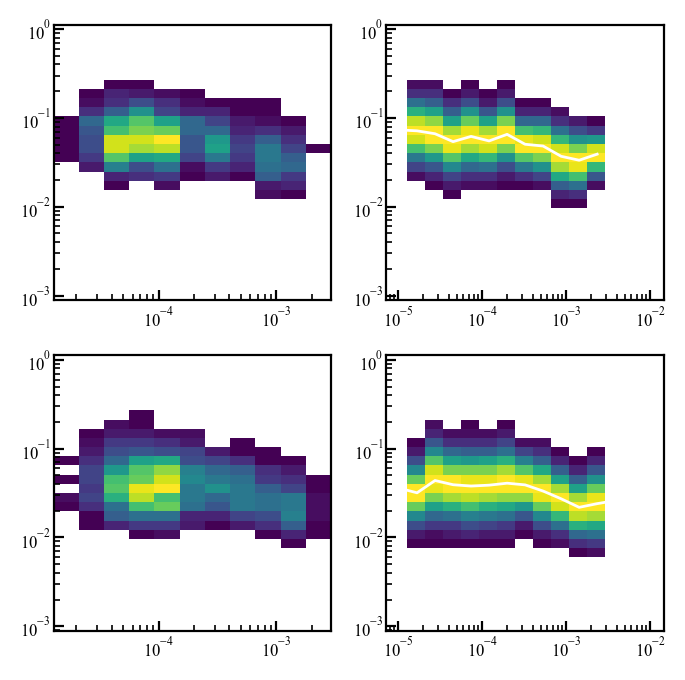

In [205]:
fig, ax = plt.subplots(2, 2, figsize=utils.cm2inch(10, 10), dpi=200)

ax[0, 0].set_xscale('log')
ax[0, 0].set_yscale('log')
ax[0, 1].set_xscale('log')
ax[0, 1].set_yscale('log')

ax[1, 0].set_xscale('log')
ax[1, 0].set_yscale('log')
ax[1, 1].set_xscale('log')
ax[1, 1].set_yscale('log')

ax[0, 0].pcolormesh(x_mesh_meas[:, 1:13], y_mesh_meas[:, 1:13], meas_hist_2d_1[:, 1:12], cmap=my_cmap_blues, vmin=-1)
ax[0, 1].pcolormesh(x_mesh_meas[:, 1:13], y_mesh_meas[:, 1:13], hist_2d_gauss_norm_meas_1[:, 1:12], cmap=my_cmap_blues)
ax[0, 1].plot(x_mesh_meas[0, :-1] + np.diff(x_mesh_meas[0, :])/2, 10**gaussian_fit_mean_meas_1, lw=1, c='w')

ax[1, 0].pcolormesh(x_mesh_meas[:, 1:13], y_mesh_meas[:, 1:13], meas_hist_2d_2[:, 1:12], cmap=my_cmap_blues, vmin=-1)
ax[1, 1].pcolormesh(x_mesh_meas[:, 1:13], y_mesh_meas[:, 1:13], hist_2d_gauss_norm_meas_2[:, 1:12], cmap=my_cmap_blues)
ax[1, 1].plot(x_mesh_meas[0, :-1] + np.diff(x_mesh_meas[0, :])/2, 10**gaussian_fit_mean_meas_2, lw=1, c='w')

In [197]:
y_mesh_meas.shape

(31, 16)

In [156]:
gaussian_fit_mean_meas_2.shape

(15,)

In [157]:
which_z = 5
which_phi = 30

ymiddle, gaussian_fit_mean, gaussian_fit_mean_err, hist_2d_gauss, hist_2d_gauss_norm = \
    fit_gaussian_to_slice(y_mesh, sim_hist_2d_all[which_z, which_phi])

In [158]:
gaussian_fit_mean.shape

(15,)

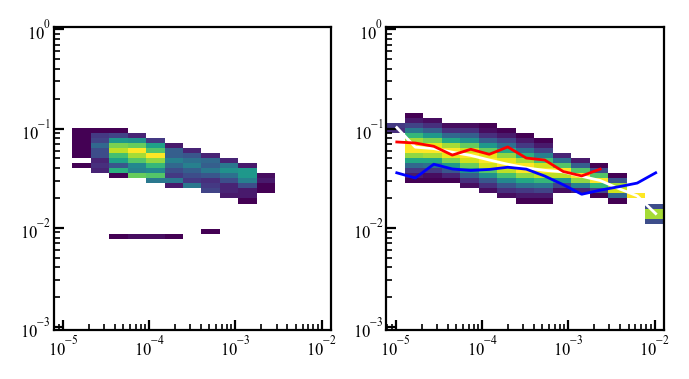

In [159]:
fig, ax = plt.subplots(1, 2, figsize=utils.cm2inch(10, 5), dpi=200)

ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[1].set_xscale('log')
ax[1].set_yscale('log')

ax[0].pcolormesh(x_mesh, y_mesh, sim_hist_2d_all[which_z, which_phi, :, :], cmap=my_cmap_blues)
ax[1].pcolormesh(x_mesh, y_mesh, hist_2d_gauss_norm, cmap=my_cmap_blues)
ax[1].plot(x_mesh[0, :-1] + np.diff(x_mesh[0, :])/2, 10**gaussian_fit_mean, lw=1, c='w')

ax[1].plot(x_mesh_meas[0, :-1] + np.diff(x_mesh_meas[0, :])/2, 10**gaussian_fit_mean_meas_1, lw=1, c='r')
ax[1].plot(x_mesh_meas[0, :-1] + np.diff(x_mesh_meas[0, :])/2, 10**gaussian_fit_mean_meas_2, lw=1, c='b')

In [160]:
which_z = 20
which_phi = 2

ymiddle, gaussian_fit_mean, gaussian_fit_mean_err, hist_2d_gauss, hist_2d_gauss_norm = \
    fit_gaussian_to_slice(y_mesh, sim_hist_2d_all[which_z, which_phi])

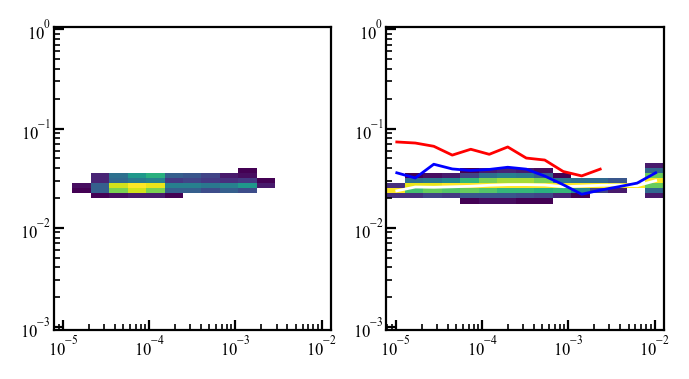

In [161]:
fig, ax = plt.subplots(1, 2, figsize=utils.cm2inch(10, 5), dpi=200)

ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[1].set_xscale('log')
ax[1].set_yscale('log')

ax[0].pcolormesh(x_mesh, y_mesh, sim_hist_2d_all[which_z, which_phi, :, :], cmap=my_cmap_blues)
ax[1].pcolormesh(x_mesh, y_mesh, hist_2d_gauss_norm, cmap=my_cmap_blues)
ax[1].plot(x_mesh[0, :-1] + np.diff(x_mesh[0, :])/2, 10**gaussian_fit_mean, lw=1, c='w')

ax[1].plot(x_mesh_meas[0, :-1] + np.diff(x_mesh_meas[0, :])/2, 10**gaussian_fit_mean_meas_1, lw=1, c='r')
ax[1].plot(x_mesh_meas[0, :-1] + np.diff(x_mesh_meas[0, :])/2, 10**gaussian_fit_mean_meas_2, lw=1, c='b')

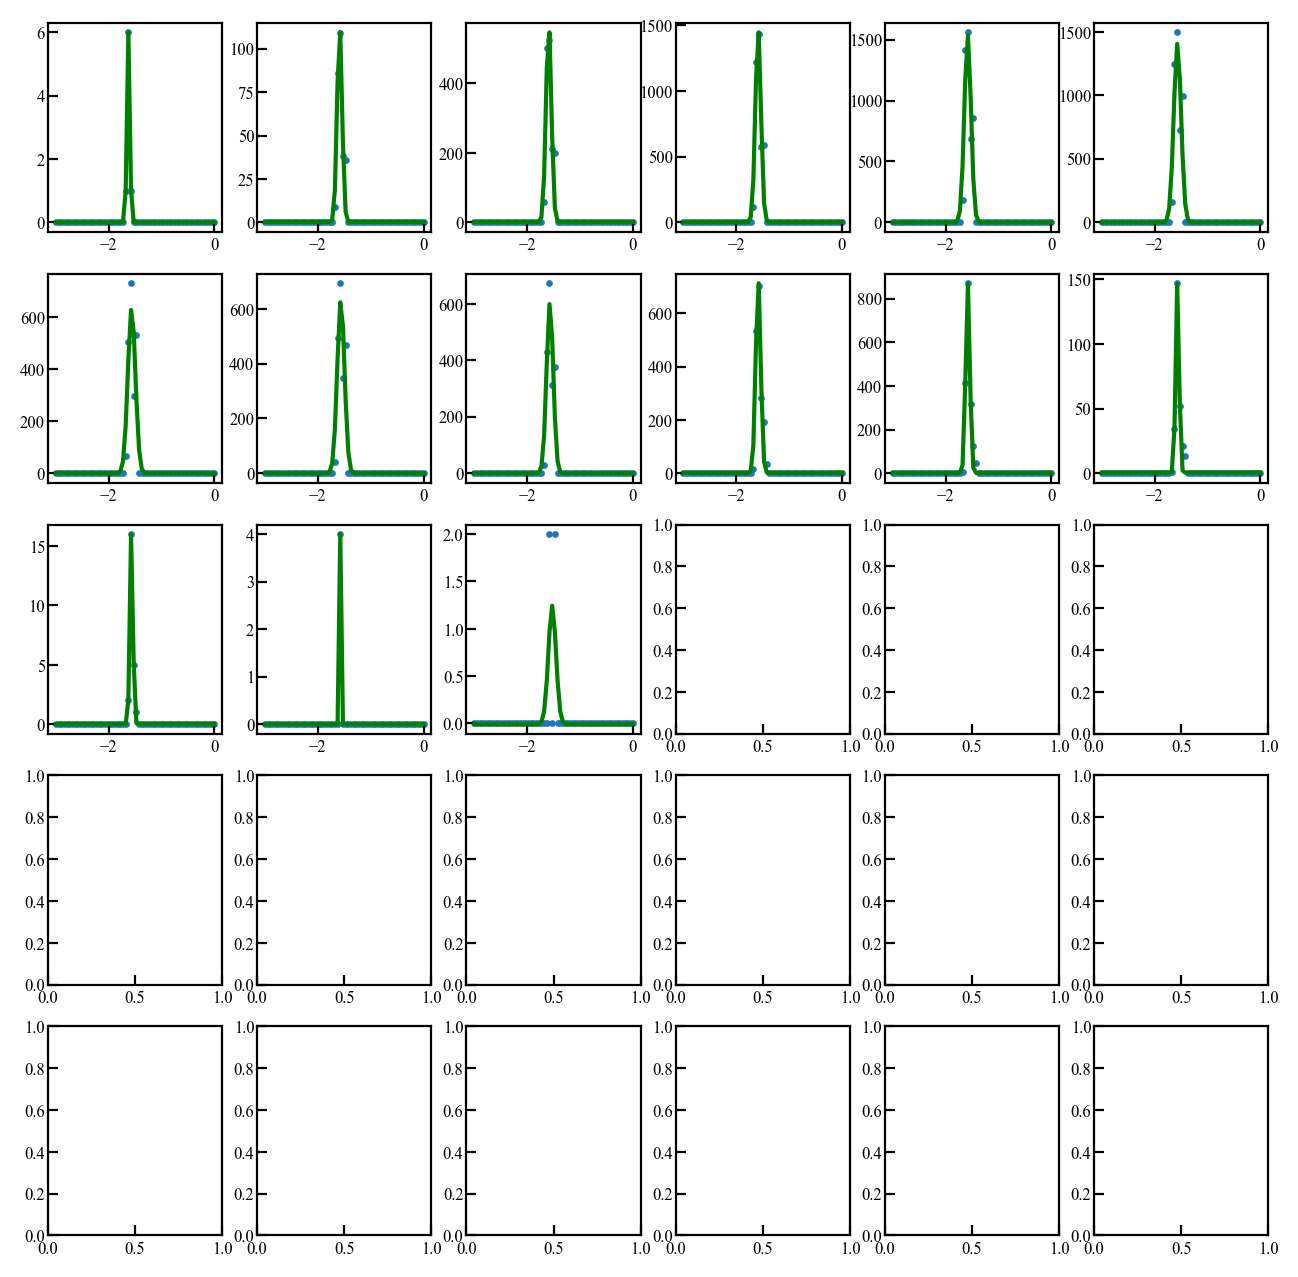

In [162]:
nr = 5
nc = 6

fig, ax = plt.subplots(nrows=nr, ncols=nc, figsize=utils.cm2inch(20, 20), dpi=200)

for i, asd in enumerate(hist_2d_gauss.T):
    ax[i//nc, i%nc].scatter(ymiddle, sim_hist_2d_all[which_z, which_phi, :, i], s=2)
    ax[i//nc, i%nc].plot(ymiddle, asd, c='g')

In [163]:
print(gaussian_fit_mean)
print(np.isnan(gaussian_fit_mean_meas_1))

[-1.62637491 -1.58818252 -1.59067358 -1.58610486 -1.58065599 -1.57059905
 -1.56448343 -1.56401461 -1.56773173 -1.58505108 -1.57864386 -1.57099135
 -1.56833386 -1.57552745 -1.52468   ]
[False False False False False False False False False False False False
  True  True False]


In [164]:
not_any_nan = np.invert(np.bitwise_or(np.isnan(gaussian_fit_mean), np.isnan(gaussian_fit_mean_meas_1)))

calc_sq_diff(y1=10**gaussian_fit_mean_meas_1[not_any_nan], y2=10**gaussian_fit_mean[not_any_nan], log_scale=False)

0.01188006793252355

In [165]:
dFluct.shape

(51,)

In [166]:
which_z = 20
which_phi = 2

sq_diff_all_1 = np.zeros((dFluct.shape[0], PhiFluct.shape[0]))
sq_diff_all_2 = np.zeros((dFluct.shape[0], PhiFluct.shape[0]))

for which_z in tqdm(range(dFluct.shape[0])):
    for which_phi in range(PhiFluct.shape[0]):
        ymiddle, gaussian_fit_mean, gaussian_fit_mean_err, hist_2d_gauss, hist_2d_gauss_norm = \
            fit_gaussian_to_slice(y_mesh, sim_hist_2d_all[which_z, which_phi])
        
        # compare with plateau 1
        not_any_nan_1 = np.invert(np.bitwise_or(np.isnan(gaussian_fit_mean[1:11]), np.isnan(gaussian_fit_mean_meas_1[1:11])))
        sq_diff_1 = calc_sq_diff(y1=10**gaussian_fit_mean_meas_1[1:11][not_any_nan_1], y2=10**gaussian_fit_mean[1:11][not_any_nan_1], log_scale=True)
        
        sq_diff_all_1[which_z, which_phi] = sq_diff_1
        
        # compare with plateau 2
        not_any_nan_2 = np.invert(np.bitwise_or(np.isnan(gaussian_fit_mean[1:11]), np.isnan(gaussian_fit_mean_meas_2[1:11])))
        sq_diff_2 = calc_sq_diff(y1=10**gaussian_fit_mean_meas_2[1:11][not_any_nan_2], y2=10**gaussian_fit_mean[1:11][not_any_nan_2], log_scale=True)
        
        sq_diff_all_2[which_z, which_phi] = sq_diff_2

  0%|          | 0/51 [00:00<?, ?it/s]

D:\mcbj_stmbj\venv\lib\site-packages\scipy\optimize\_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\Users\Admin\AppData\Local\Temp\ipykernel_12608\1110183324.py:44: RuntimeWarning: invalid value encountered in sqrt
  perr = np.sqrt(np.diag(pcov))
C:\Users\Admin\AppData\Local\Temp\ipykernel_12608\1110183324.py:32: RuntimeWarning: invalid value encountered in sqrt
  perr = np.sqrt(np.diag(pcov))


In [167]:
min(sq_diff_all_2.flatten())

0.04329320437966442

In [168]:
def plot_sq_diff_1(dFluct, PhiFluct, sq_diff_all_1, sq_diff_all_2, plot_min=True, xlim=None, ylim=None, **kwargs):
    
    fig, ax = plt.subplots(ncols=2, figsize=utils.cm2inch(14, 5), dpi=300)

    # xbins = PhiFluct
    # ybins = dFluct

    # print(np.diff(PhiFluct)[0])
    # print(np.diff(dFluct)[0])
    
    ind1 = np.unravel_index(np.argmin(sq_diff_all_1, axis=None), sq_diff_all_1.shape)
    ind2 = np.unravel_index(np.argmin(sq_diff_all_2, axis=None), sq_diff_all_2.shape)

    x_mesh, y_mesh = np.meshgrid(dFluct, PhiFluct)

    im1 = ax[0].pcolormesh(x_mesh, y_mesh, sq_diff_all_1.T, cmap='hot', **kwargs)
    fig.colorbar(im1, ax=ax[0], extend='max')
    im2 = ax[1].pcolormesh(x_mesh, y_mesh, sq_diff_all_2.T, cmap='hot', **kwargs)
    fig.colorbar(im2, ax=ax[1], extend='max')

    # ax[0].scatter(PhiFluct[ind1[0]], dFluct[ind1[1]], c='white', s=1)
    # ax[1].plot(PhiFluct[ind2[0]], dFluct[ind2[1]], markersize=1, marker='s', fillstyle='none')

    # Create a Rectangle patch
    # rect1 = patches.Rectangle((dFluct[ind1[1]]-0.00005, PhiFluct[ind1[0]]-0.0005), 0.001, 0.0001, linewidth=0.5, edgecolor='orange', facecolor='none')
    # rect2 = patches.Rectangle((dFluct[ind2[1]]-0.00005, PhiFluct[ind2[0]]-0.0005), 0.001, 0.0001, linewidth=0.5, edgecolor='orange', facecolor='none')

    # Add the patch to the Axes
    # ax[0].add_patch(rect1)
    # ax[1].add_patch(rect2)
    
    if plot_min:
        ax[0].scatter(dFluct[ind1[0]], PhiFluct[ind1[1]], s=1, label=f'({np.round(dFluct[ind1[0]], 5)}, {np.round(PhiFluct[ind1[1]], 5)})')
        ax[1].scatter(dFluct[ind2[0]], PhiFluct[ind2[1]], s=1, label=f'({np.round(dFluct[ind2[0]], 5)}, {np.round(PhiFluct[ind2[1]], 5)})')
    
    if xlim is not None:
        ax[0].set_xlim(xlim[0], xlim[1])
        ax[1].set_xlim(xlim[0], xlim[1])
    if ylim is not None:
        ax[0].set_ylim(ylim[0], ylim[1])
        ax[1].set_ylim(ylim[0], ylim[1])

    ax[0].set_xlabel(r'$\Delta z\;[\mathrm{nm}]$')
    ax[0].set_ylabel(r'$\Delta \phi\;[\mathrm{eV}]$')
    ax[1].set_xlabel(r'$\Delta z\;[\mathrm{nm}]$')
    ax[1].set_ylabel(r'$\Delta \phi\;[\mathrm{eV}]$')
    
    ax[0].legend(fontsize=6)
    ax[1].legend(fontsize=6)
    
    return ax

array([<AxesSubplot:xlabel='$\\Delta z\\;[\\mathrm{nm}]$', ylabel='$\\Delta \\phi\\;[\\mathrm{eV}]$'>,
       <AxesSubplot:xlabel='$\\Delta z\\;[\\mathrm{nm}]$', ylabel='$\\Delta \\phi\\;[\\mathrm{eV}]$'>],
      dtype=object)

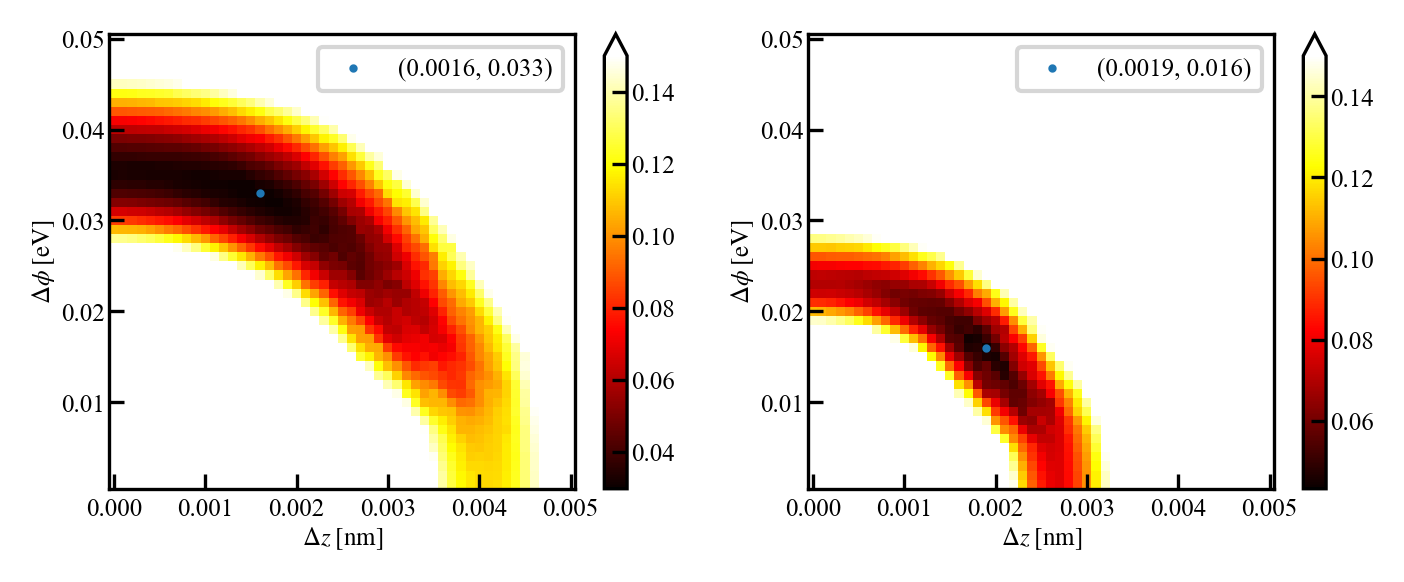

In [209]:
plot_sq_diff_1(dFluct=dFluct, PhiFluct=PhiFluct, sq_diff_all_1 = sq_diff_all_1, sq_diff_all_2=sq_diff_all_2, plot_min=True, vmax=0.15)

In [170]:
ind1 = np.unravel_index(np.argmin(sq_diff_all_1, axis=None), sq_diff_all_1.shape)
ind2 = np.unravel_index(np.argmin(sq_diff_all_2, axis=None), sq_diff_all_2.shape)

In [208]:
print(min(sq_diff_all_1.flatten()))
print(min(sq_diff_all_2.flatten()))

0.02969564712878115
0.04329320437966442


16 32
0.0016 0.033


(0.01, 0.2)

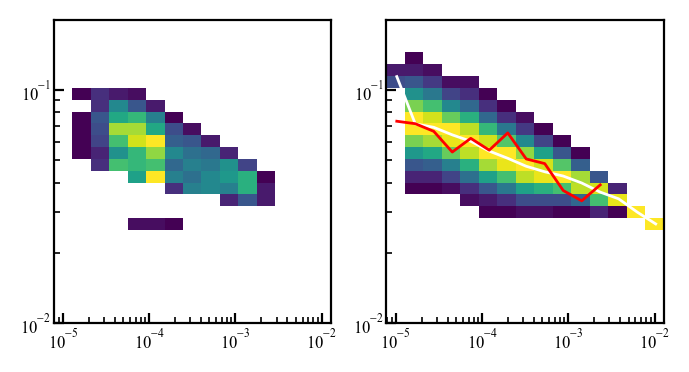

In [182]:
which_z = ind1[0]
which_phi = ind1[1]

print(which_z, which_phi)
print(dFluct[which_z], PhiFluct[which_phi])

fig, ax = plt.subplots(1, 2, figsize=utils.cm2inch(10, 5), dpi=200)

ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[1].set_xscale('log')
ax[1].set_yscale('log')

ax[0].pcolormesh(x_mesh, y_mesh, sim_hist_2d_all[which_z, which_phi, :, :], cmap=my_cmap_blues, vmin=0)

ymiddle, gaussian_fit_mean, gaussian_fit_mean_err, hist_2d_gauss, hist_2d_gauss_norm = \
    fit_gaussian_to_slice(y_mesh, sim_hist_2d_all[which_z, which_phi])

ax[1].pcolormesh(x_mesh, y_mesh, hist_2d_gauss_norm, cmap=my_cmap_blues, vmin=0)
ax[1].plot(x_mesh[0, :-1] + np.diff(x_mesh[0, :])/2, 10**gaussian_fit_mean, lw=1, c='w')

ax[1].plot(x_mesh_meas[0, :-1] + np.diff(x_mesh_meas[0, :])/2, 10**gaussian_fit_mean_meas_1, lw=1, c='r')

ax[0].set_ylim(1e-2, 2e-1)
ax[1].set_ylim(1e-2, 2e-1)

19 15
0.0019 0.016


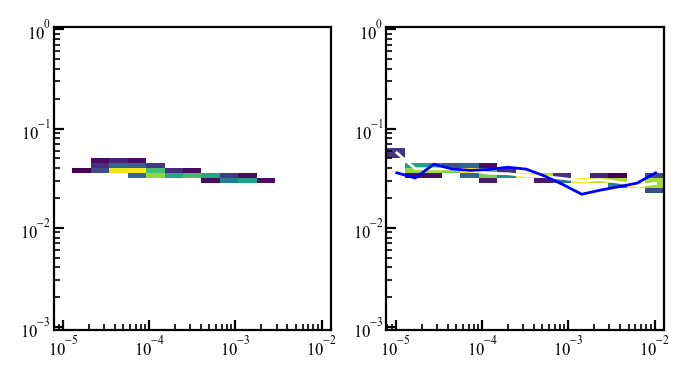

In [172]:
which_z = ind2[0]
which_phi = ind2[1]

print(which_z, which_phi)
print(dFluct[which_z], PhiFluct[which_phi])

fig, ax = plt.subplots(1, 2, figsize=utils.cm2inch(10, 5), dpi=200)

ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[1].set_xscale('log')
ax[1].set_yscale('log')

ax[0].pcolormesh(x_mesh, y_mesh, sim_hist_2d_all[which_z, which_phi, :, :], cmap=my_cmap_blues, vmin=0)


ymiddle, gaussian_fit_mean, gaussian_fit_mean_err, hist_2d_gauss, hist_2d_gauss_norm = \
    fit_gaussian_to_slice(y_mesh, sim_hist_2d_all[which_z, which_phi])

ax[1].pcolormesh(x_mesh, y_mesh, hist_2d_gauss_norm, cmap=my_cmap_blues, vmin=0)
ax[1].plot(x_mesh[0, :-1] + np.diff(x_mesh[0, :])/2, 10**gaussian_fit_mean, lw=1, c='w')

ax[1].plot(x_mesh_meas[0, :-1] + np.diff(x_mesh_meas[0, :])/2, 10**gaussian_fit_mean_meas_2, lw=1, c='b')

In [173]:
igor_test

array([[ 9.9999997e-06, -9.7392988e-01],
       [ 1.5848931e-05, -1.1577749e+00],
       [ 2.5118865e-05, -1.1699499e+00],
       [ 3.9810719e-05, -1.1942134e+00],
       [ 6.3095737e-05, -1.2226955e+00],
       [ 9.9999997e-05, -1.2621658e+00],
       [ 1.5848932e-04, -1.2838136e+00],
       [ 2.5118864e-04, -1.3224260e+00],
       [ 3.9810716e-04, -1.3468728e+00],
       [ 6.3095737e-04, -1.3588808e+00],
       [ 1.0000000e-03, -1.3830330e+00],
       [ 1.5848932e-03, -1.4125746e+00],
       [ 2.5118864e-03, -1.4406391e+00],
       [ 3.9810715e-03, -1.4659332e+00],
       [ 6.3095735e-03, -1.5000000e+00],
       [ 9.9999998e-03, -1.5275433e+00],
       [ 1.5848933e-02, -2.0000000e+00],
       [ 2.5118865e-02, -2.0000000e+00],
       [ 3.9810717e-02, -2.0000000e+00],
       [ 6.3095734e-02, -2.0000000e+00],
       [ 1.0000000e-01, -2.0000000e+00]])

(0.005, 0.3)

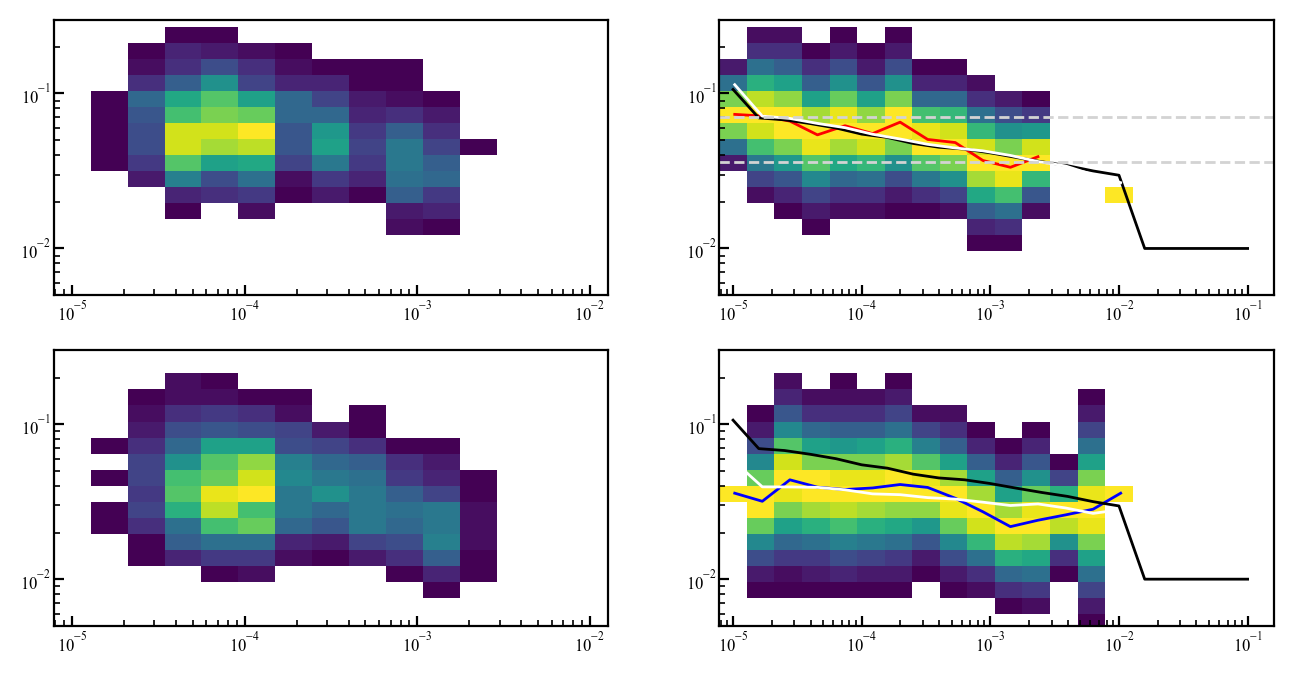

In [181]:
fig, ax = plt.subplots(2, 2, figsize=utils.cm2inch(20, 10), dpi=200)

ax[0, 0].set_xscale('log')
ax[0, 0].set_yscale('log')
ax[0, 1].set_xscale('log')
ax[0, 1].set_yscale('log')

ax[1, 0].set_xscale('log')
ax[1, 0].set_yscale('log')
ax[1, 1].set_xscale('log')
ax[1, 1].set_yscale('log')

ymiddle, gaussian_fit_mean_sim_1, gaussian_fit_mean_err_sim_1, hist_2d_gauss_sim_1, hist_2d_gauss_norm_sim_1 = \
    fit_gaussian_to_slice(y_mesh, sim_hist_2d_all[ind1[0], ind1[1]])

ax[0, 0].pcolormesh(x_mesh_meas, y_mesh_meas, meas_hist_2d_1, cmap=my_cmap_blues, vmin=0)
ax[0, 1].pcolormesh(x_mesh_meas, y_mesh_meas, hist_2d_gauss_norm_meas_1, cmap=my_cmap_blues, vmin=0)
ax[0, 1].plot(x_mesh_meas[0, :-1] + np.diff(x_mesh_meas[0, :])/2, 10**gaussian_fit_mean_meas_1, lw=1, c='r')
ax[0, 1].plot(igor_test[:, 0], 10**igor_test[:, 1], lw=1, c='k')
ax[0, 1].plot(x_mesh[0, :-1] + np.diff(x_mesh[0, :])/2, 10**gaussian_fit_mean_sim_1, lw=1, c='w')

ymiddle, gaussian_fit_mean_sim_2, gaussian_fit_mean_err_sim_2, hist_2d_gauss_sim_2, hist_2d_gauss_norm_sim_2 = \
    fit_gaussian_to_slice(y_mesh, sim_hist_2d_all[ind2[0], ind2[1]])

ax[0, 1].axhline(7e-2, ls='--', lw=1, c='lightgrey')
ax[0, 1].axhline(3.6e-2, ls='--', lw=1, c='lightgrey')

ax[1, 0].pcolormesh(x_mesh_meas, y_mesh_meas, meas_hist_2d_2, cmap=my_cmap_blues, vmin=0)
ax[1, 1].pcolormesh(x_mesh_meas, y_mesh_meas, hist_2d_gauss_norm_meas_2, cmap=my_cmap_blues, vmin=0)
ax[1, 1].plot(x_mesh_meas[0, :-1] + np.diff(x_mesh_meas[0, :])/2, 10**gaussian_fit_mean_meas_2, lw=1, c='b')
ax[1, 1].plot(x_mesh[0, :-1] + np.diff(x_mesh[0, :])/2, 10**gaussian_fit_mean_sim_2, lw=1, c='w')

ax[1, 1].plot(igor_test[:, 0], 10**igor_test[:, 1], lw=1, c='k')

ax[0, 0].set_ylim(5e-3, 3e-1)
ax[0, 1].set_ylim(5e-3, 3e-1)
ax[1, 0].set_ylim(5e-3, 3e-1)
ax[1, 1].set_ylim(5e-3, 3e-1)

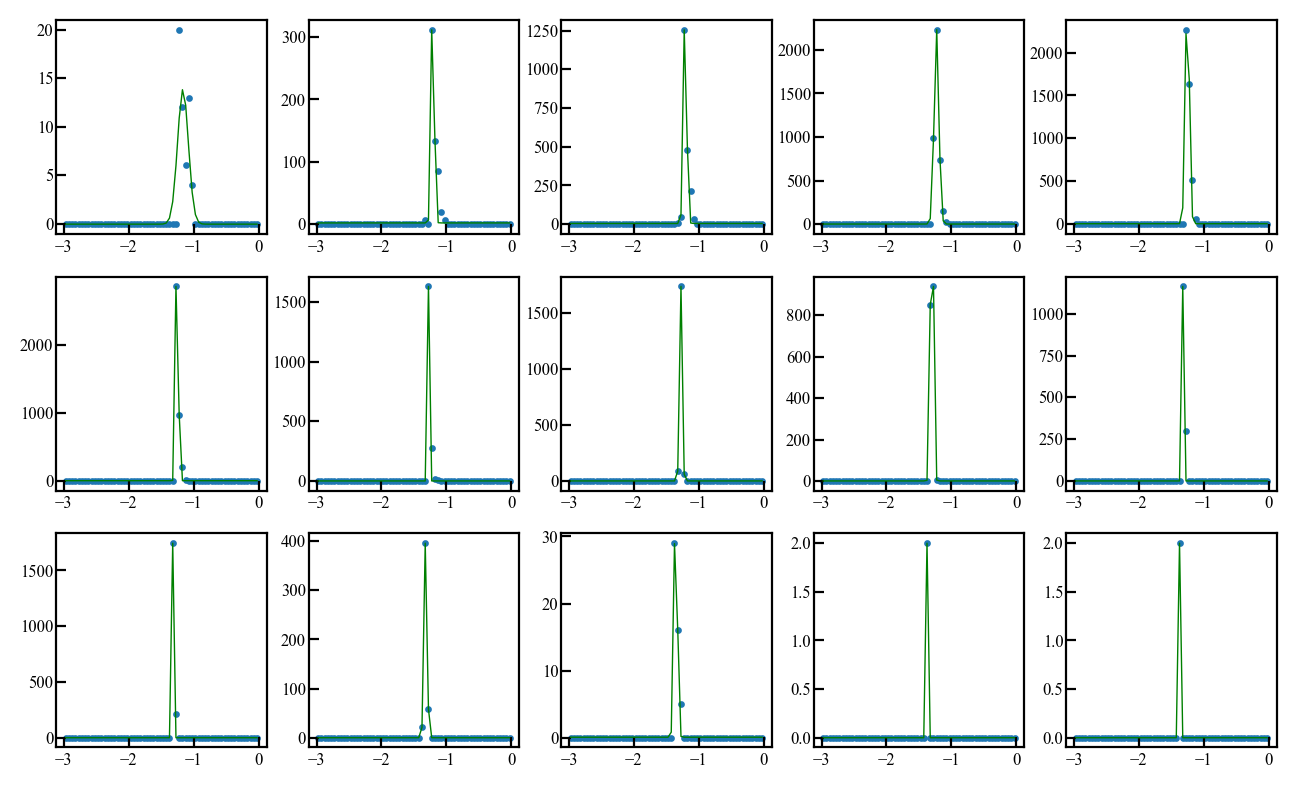

In [105]:
nr = 3
nc = 5

fig, ax = plt.subplots(nrows=nr, ncols=nc, figsize=utils.cm2inch(20, 12), dpi=200)

for i, asd in enumerate(hist_2d_gauss_sim_1.T):
    ax[i//nc, i%nc].plot(ymiddle, asd, c='g', lw=0.5)
    ax[i//nc, i%nc].scatter(ymiddle, sim_hist_2d_all[ind1[0], ind1[1], :, i], s=2)


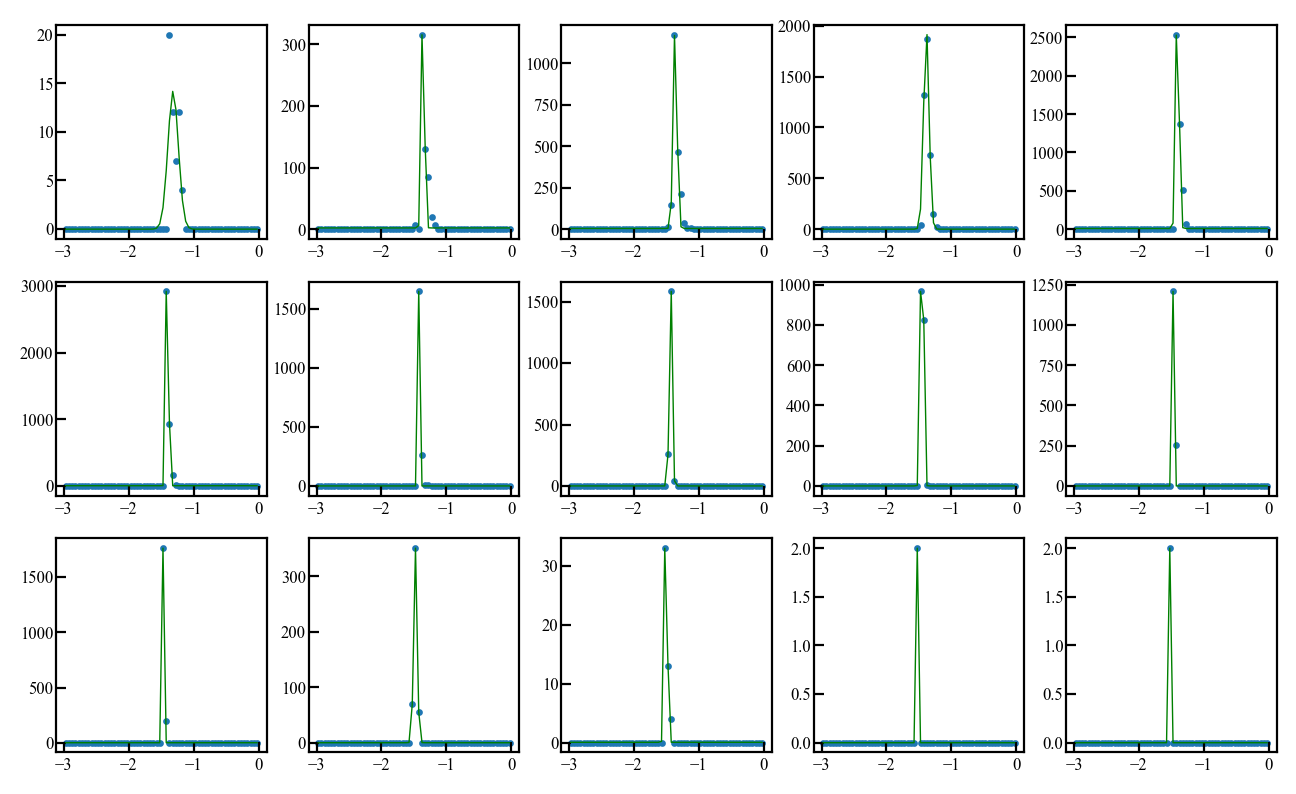

In [107]:
nr = 3
nc = 5

fig, ax = plt.subplots(nrows=nr, ncols=nc, figsize=utils.cm2inch(20, 12), dpi=200)

for i, asd in enumerate(hist_2d_gauss_sim_2.T):
    ax[i//nc, i%nc].plot(ymiddle, asd, c='g', lw=0.5)
    ax[i//nc, i%nc].scatter(ymiddle, sim_hist_2d_all[ind2[0], ind2[1], :, i], s=2)
